### Topic: Multiple plant disease classification using CNN and Transfer learning


### Data: subset of plant village data set consisting of tomato, potato, pepper
This subset comprises 20,638 images distributed across 15 distinct plant classes. 80 % of data was used for training (16516 images), while the remaining 20% was used for (4122 images)


### Aim
The primary objective of this study is to build a customized Convolutional Neural Network (CNN) model specifically tailored for the classification of multiple plant diseases. Subsequently, we aim to assess its performance by subjecting it to a comparative evaluation against seven pre-trained architectures, namely VGG16, VGG19, ResNet50, DenseNet 121, Inception V4, EfficientNet, and MobileNet.


###  Objectives.
1. Designing a specialized CNN architecture tailored for plant disease classification with a focus on achieving high accuracy.
2. Conducting a comparative analysis to assess how the performance of the custom-designed CNN architecture measures up against pretrained models.
3. Thoroughly evaluating the effectiveness of various optimization algorithms when applied to the top-performing models.


### Import the necessary liberies

In [ ]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs
import random                                                                                    # Importing random to  Fixing the seed for random number generators
import shutil                                                                                    # Importing shutil to copy file from one path to another path
from PIL import Image                                                                            # importing Image to resize the image
import imghdr                                                                                    # to recorgnise anytype of image

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adadelta,Adamax,Adagrad                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix, classification_report                              # Importing to plot the confusion matrix, classification report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#from tensorflow.keras.callbacks import TensorBoard


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Data preprocessing
The dataset is in one folder we need to separate it into traing and testing data

### load the data

In [ ]:
input_dir = "PlantVillage"
os.listdir(input_dir )

['Potato___Late_blight',
 'Pepper__bell___healthy',
 'Pepper__bell___Bacterial_spot',
 'Potato___Early_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

###  Prepare training and testing images

### creating the training and testing path


In [ ]:
# to automatically creat a folder. you can also do it manually

# check if the path traing exit or not creat that folder

def create_directory(train,test,category):
    if not os.path.exists(train):
        os.makedirs(train) # treat train directory
    if not os.path.exists(test):
        os.makedirs(test) # create test directory
    if not os.path.exists(os.path.join(train,category)): # if the caterogy does not exist in the traing file create it
        os.makedirs(os.path.join(train,category))
    if not os.path.exists(os.path.join(test,category)): # if the caterogy does not exist in the test file create it
        os.makedirs(os.path.join(test,category)) # creat test category

### Splitting the data into training and testing sets and resizing the images

In [ ]:
def resize_image(image_file, output_size=(64, 64)):
    # Load the image using OpenCV
    img = cv2.imread(image_file)
    # Resize the image to the specified output size (64x64)
    img = cv2.resize(img, output_size)
    return img

def get_image(input_dir, category):
    # image directory
    img_dir = os.path.join(input_dir, category)

    # define the percentage of images to use for testing
    test_percent = 0.2

    # get a list of all files in the image directory
    all_files = os.listdir(img_dir)

    # sanity check (make sure the files are in the same format) # not compulsory
    image_files = [os.path.join(img_dir, f) for f in all_files if os.path.isfile(os.path.join(img_dir, f)) and imghdr.what(os.path.join(img_dir, f))]

    # shuffle the images to make sure your model is not biased
    random.shuffle(image_files)

    # calculate the number of images to use for training and testing
    num_images = len(image_files)
    num_test = int(test_percent * num_images)
    num_train = num_images - num_test

    # create paths for training and testing
    train_dir = os.path.join(input_dir, "train")
    test_dir = os.path.join(input_dir, "test")

    # create actual training and testing folder (directory)
    create_directory(train_dir, test_dir, category)

    # copy and resize the images to the training and testing directories
    for i in range(num_images):
        img_file = image_files[i]
        img = resize_image(img_file, output_size=(64, 64))  # Resize the image to 64x64

        if i < num_train:
            # Copy the image to the training directory
            shutil.copy(img_file, os.path.join(train_dir, category))
            # Save the resized image to the training directory
            cv2.imwrite(os.path.join(train_dir, category, os.path.basename(img_file)), img)
        else:
            # Copy the image to the testing directory
            shutil.copy(img_file, os.path.join(test_dir, category))
            # Save the resized image to the testing directory
            cv2.imwrite(os.path.join(test_dir, category, os.path.basename(img_file)), img)

In [ ]:
# list of my catigories
categories = os.listdir(input_dir)

for category in categories:
    get_image(input_dir, category)

In [ ]:
# check the size of the images
def checkimagesize(dir, category):
    cat_path=os.path.join(dir,category)
    images = os.listdir(cat_path)


###  loading the training and testing data set

In [ ]:
train_dir ="train"

test_dir ="test"

#### First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

###  **Data Augmentation**
In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs. To overcome this problem, one approach we might consider is **Data Augmentation**. CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. <br> Taking this attribute into account, we can augment the images using the techniques listed below - <br>
**1. Horizontal Flip** (should be set to True/False) <br>
**2. Vertical Flip** (should be set to True/False) <br>
**3. Height Shift** (should be between 0 and 1) <br>
**4. Width Shift** (should be between 0 and 1) <br>
**5. Rotation** (should be between 0 and 180) <br>
**6. Shear** (should be between 0 and 1) <br>
**7. Zoom** (should be between 0 and 1) etc. <br>

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


##### listing out the labels of our data

In [ ]:
# Generating a list of class labels based on the class indices from the train_generator
labels = [k for k in train_generator.class_indices]
labels

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

There are 15 distinct classes present in our data set

### Visualizing the 15 distinct classes present in our data set

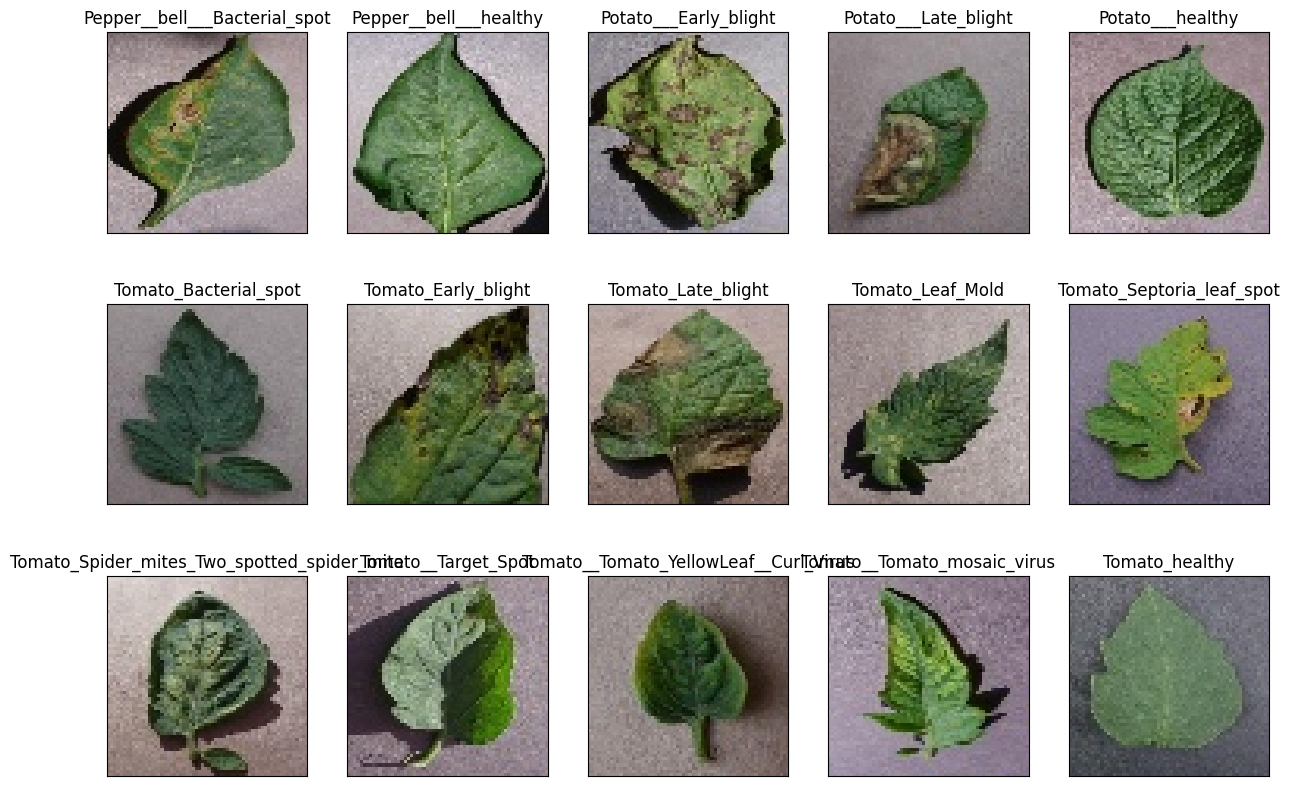

In [ ]:
# plot
fig = plt.figure(figsize=(15, 10))

# Iterate through each label and display an image for each category
for i in range(len(labels)):
    ax = fig.add_subplot(3, 5, 1+i, xticks=[], yticks=[])

    # Construct the directory path for the current class
    class_dir = os.path.join(train_dir, labels[i])

    # Get the list of image filenames in the class directory
    img_filenames = os.listdir(class_dir)

    # Construct the path of the first image in the class
    img_path = os.path.join(class_dir, img_filenames[0])

    # Load and display the image
    im = plt.imread(img_path)
    ax.set_title(labels[i])
    plt.imshow(im)

plt.show()


### Visualizing the augumentation done to transform our data

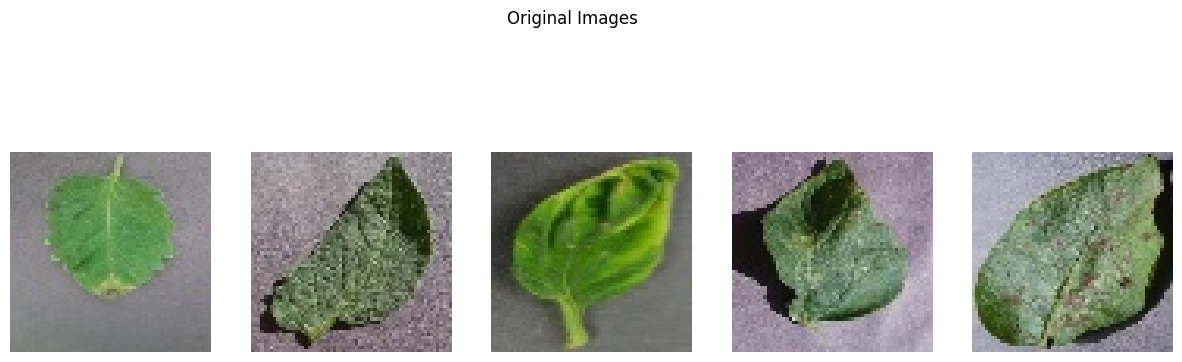

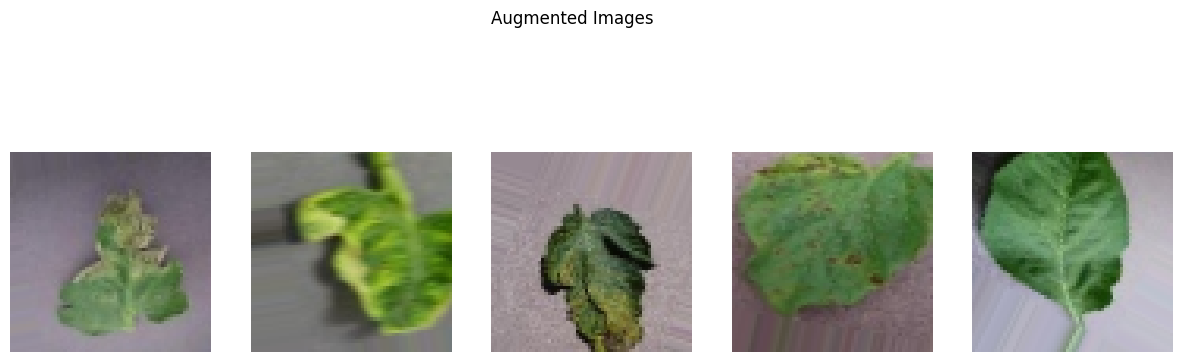

In [ ]:
from tensorflow.keras.preprocessing import image  # Import the 'image' module from TensorFlow Keras

# Create a function to display images
def plot_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

# Generate augmented images
num_samples_to_plot = 5  # Number of samples to plot
augmented_images = []

for _ in range(num_samples_to_plot):
    # Get a batch of augmented images
    augmented_batch, _ = next(train_generator)

    # Select one image from the batch
    augmented_image = augmented_batch[0]

    # Append the augmented image to the list
    augmented_images.append(augmented_image)

# Load a few original images from the training dataset
original_images = []
for _ in range(num_samples_to_plot):
    # Load an original image from the training dataset
    original_image_path = train_generator.filepaths[np.random.randint(0, len(train_generator.filepaths))]
    original_img = image.load_img(original_image_path, target_size=(64, 64))
    original_img = image.img_to_array(original_img) / 255.0  # Normalize to [0, 1]

    # Append the original image to the list
    original_images.append(original_img)

# Plot the original and augmented images
plot_images(original_images, title="Original Images")
plot_images(augmented_images, title="Augmented Images")


###  Visualizing the distribution  of the training and testing data set


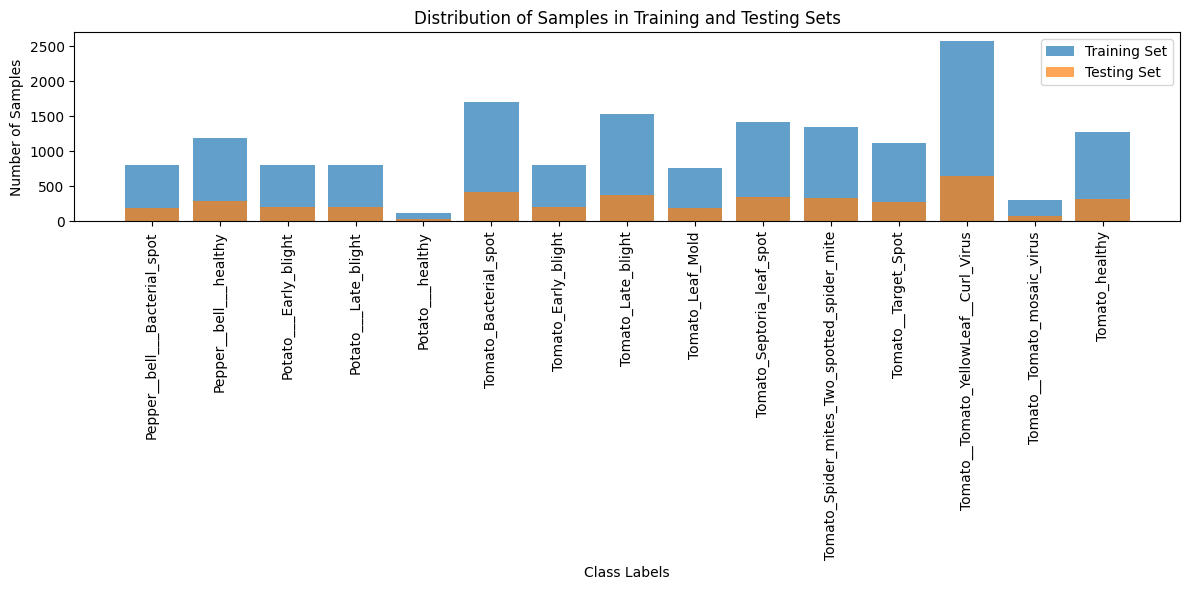

In [ ]:

# Count the number of samples in each class for the training set
train_class_counts = [train_generator.classes.tolist().count(i) for i in range(len(labels))]

# Count the number of samples in each class for the testing set
test_class_counts = [test_generator.classes.tolist().count(i) for i in range(len(labels))]

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(labels, train_class_counts, label='Training Set', alpha=0.7)
plt.bar(labels, test_class_counts, label='Testing Set', alpha=0.7)
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples in Training and Testing Sets')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

# Display the bar chart
plt.show()


 the distribution of the data is not balance

### Display the number of sample belonging to the training and test dataset

#### - Training data set

In [ ]:
# Initialize a dictionary to store the counts of each class
class_counts = {}

# Iterate through the subdirectories in the training directory
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    # Check if it's a directory
    if os.path.isdir(class_path):
        # Count the number of files (images) in the directory
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Print the length of each class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")


Class 'Pepper__bell___Bacterial_spot': 798 images
Class 'Pepper__bell___healthy': 1183 images
Class 'Potato___Early_blight': 800 images
Class 'Potato___healthy': 122 images
Class 'Potato___Late_blight': 800 images
Class 'Tomato_Bacterial_spot': 1702 images
Class 'Tomato_Early_blight': 800 images
Class 'Tomato_healthy': 1273 images
Class 'Tomato_Late_blight': 1528 images
Class 'Tomato_Leaf_Mold': 762 images
Class 'Tomato_Septoria_leaf_spot': 1417 images
Class 'Tomato_Spider_mites_Two_spotted_spider_mite': 1341 images
Class 'Tomato__Target_Spot': 1124 images
Class 'Tomato__Tomato_mosaic_virus': 299 images
Class 'Tomato__Tomato_YellowLeaf__Curl_Virus': 2567 images


#### - Testing data set

In [ ]:
# Initialize a dictionary to store the counts of each class
class_counts = {}

# Iterate through the subdirectories in the training directory
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)

    # Check if it's a directory
    if os.path.isdir(class_path):
        # Count the number of files (images) in the directory
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Print the length of each class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

Class 'Pepper__bell___Bacterial_spot': 199 images
Class 'Pepper__bell___healthy': 295 images
Class 'Potato___Early_blight': 200 images
Class 'Potato___healthy': 30 images
Class 'Potato___Late_blight': 200 images
Class 'Tomato_Bacterial_spot': 425 images
Class 'Tomato_Early_blight': 200 images
Class 'Tomato_healthy': 318 images
Class 'Tomato_Late_blight': 381 images
Class 'Tomato_Leaf_Mold': 190 images
Class 'Tomato_Septoria_leaf_spot': 354 images
Class 'Tomato_Spider_mites_Two_spotted_spider_mite': 335 images
Class 'Tomato__Target_Spot': 280 images
Class 'Tomato__Tomato_mosaic_virus': 74 images
Class 'Tomato__Tomato_YellowLeaf__Curl_Virus': 641 images


The study utilized a subset of the Plant Village dataset, specifically focusing on tomato, potato, and pepper plant. This subset comprises a total of 20,638 images distributed across 15 distinct classes of healthy and diseased plant. To mitigate overfitting, 80 % of data was use for training (16516 images) while the remaining 20% was used for (4122 images). Importantly, both the training and testing sets include all the 15 classes

# Building our Custom model

The customized model architecture was developed from scratch by carefully fine-tuning various hyperparameters, such as the number of convolutional layers, optimizer choices, and batch size


### Creating Function for model visualization and model prediction



#### - Function for model visualization

In [ ]:
# Function for model visualization

def visualize_model_performance(hist):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training loss against validation loss
    ax1.plot(hist.history['loss'], label='Training Loss')
    ax1.plot(hist.history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot training accuracy against validation accuracy
    ax2.plot(hist.history['accuracy'], label='Training Accuracy')
    ax2.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Show the plot
    plt.show()

#### Function for model prediction and plot confusion matric and classification report

In [ ]:
# Function for model prediction

#import numpy as np
#from sklearn import metrics
#import matplotlib.pyplot as plt
import itertools

def evaluate_and_plot(model, test_generator):
    # Initialize lists to store true labels and predicted labels
    y_real = []
    all_pred = []

    # Iterate through the test data generator to make predictions
    for x, y in test_generator:
        predict = model.predict(x, verbose=0)

        # Append predicted labels to the all_pred list
        for i in predict:
            all_pred.append(np.argmax(i) + 1)

        # Convert true labels to their corresponding class indices and append to y_real
        for i in y:
            i = np.argmax(i) + 1
            y_real.append(i)

        # Break the loop if we have processed all test samples
        if len(y_real) == len(test_generator.filepaths):
            break

    # Create target names for classification report
    target_names = list(test_generator.class_indices.keys())

    # Generate classification report
    report = metrics.classification_report(y_real, all_pred, target_names=target_names)
    print("Classification Report:")
    print(report)

    # Generate confusion matrix
    conf_matrix = metrics.confusion_matrix(y_real, all_pred)

    def plot_confusion_matrix(cnf_matrix, class_names=target_names, title='Confusion matrix', cmap=plt.cm.Blues, file_name='confusion_matrix.png'):
        # Plot the confusion matrix
        plt.figure(figsize=(10, 10))
        plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
        plt.title(title)
        cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Adjust fraction and pad here
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)

        # Add numbers to each cell of the plot
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, format(cnf_matrix[i, j], 'd'),
                     horizontalalignment="center", verticalalignment='center',
                     color="white" if cnf_matrix[i, j] > cnf_matrix.max() / 2 else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(file_name)

        return

    # Plot the confusion matrix
    plot_confusion_matrix(conf_matrix)


### Define model architecture


#### Trial base model

In [ ]:
    # Define the model architecture
model = Sequential()

# Convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
# Input shape is (64, 64, 3)
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))

# Max-pooling layer with a 2x2 pool size
model.add(MaxPooling2D((2, 2)))

# Add another convolutional block
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

# Add another convolutional block
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Add a dense (fully connected) layer with 128 units and ReLU activation
model.add(Dense(128, activation="relu"))

# Add dropout regularization with a rate of 0.5 to prevent overfitting
model.add(Dropout(0.5))

# Output layer with 15 units (assuming 15 classes) and softmax activation for classification
model.add(Dense(15, activation="softmax"))


In [ ]:
# compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# check the summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

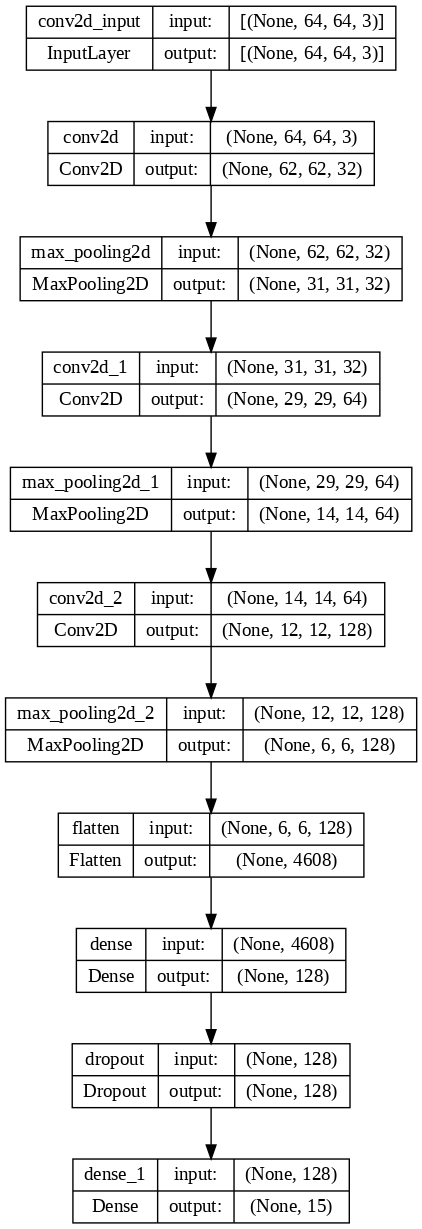

In [ ]:
from tensorflow.keras.utils import plot_model

# Set the DPI value to reduce the size of the image
dpi_value = 100

# Visualize the model and save the image with adjusted DPI value
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, dpi=dpi_value)


#### Define the file path where all the different  model checkpoints will be saved

In [ ]:
# Define the file path where the model checkpoints will be saved
model_filepath = "D:/Ajala ai"

### Define model check point

In [ ]:
# The best model will be saved as "plant.hdf5"
check = ModelCheckpoint(os.path.join(model_filepath, "plant.hdf5"), save_best_only=True, verbose=1)

# Create an EarlyStopping callback to stop training if the validation loss does not improve for 3 consecutive epochs
es = EarlyStopping(patience=5)

# Create a list of callbacks to be used during model training
callback_list = [check, es]

### Training our model

In [ ]:
### train the network

# because we loading the data from the directory we not to specifiy steps_per_epoch=
#  steps_per_epoch= number of interation per epoch = total image // by bach size

# can not use valiation split because we loading the image from a folder


history = model.fit(train_generator, steps_per_epoch=train_generator.samples // 32,validation_data=test_generator, validation_steps=test_generator.samples//32, epochs=30 , callbacks=callback_list)

Epoch 1/30
516/516 [==============================] - ETA: 0s - loss: 2.1078 - accuracy: 0.3177
Epoch 1: val_loss improved from inf to 1.43970, saving model to D:/Ajala ai\plant.hdf5
516/516 [==============================] - 77s 133ms/step - loss: 2.1078 - accuracy: 0.3177 - val_loss: 1.4397 - val_accuracy: 0.5347
Epoch 2/30
515/516 [============================>.] - ETA: 0s - loss: 1.4307 - accuracy: 0.5374
Epoch 2: val_loss improved from 1.43970 to 0.93895, saving model to D:/Ajala ai\plant.hdf5
516/516 [==============================] - 13s 26ms/step - loss: 1.4307 - accuracy: 0.5373 - val_loss: 0.9389 - val_accuracy: 0.6650
Epoch 3/30
516/516 [==============================] - ETA: 0s - loss: 1.1319 - accuracy: 0.6252
Epoch 3: val_loss improved from 0.93895 to 0.78117, saving model to D:/Ajala ai\plant.hdf5
516/516 [==============================] - 14s 26ms/step - loss: 1.1319 - accuracy: 0.6252 - val_loss: 0.7812 - val_accuracy: 0.7178
Epoch 4/30
515/516 [=======================

516/516 [==============================] - 13s 26ms/step - loss: 0.3989 - accuracy: 0.8724 - val_loss: 0.2671 - val_accuracy: 0.9089
Epoch 29/30
515/516 [============================>.] - ETA: 0s - loss: 0.3993 - accuracy: 0.8666
Epoch 29: val_loss improved from 0.26712 to 0.26035, saving model to D:/Ajala ai\plant.hdf5
516/516 [==============================] - 14s 26ms/step - loss: 0.3995 - accuracy: 0.8667 - val_loss: 0.2604 - val_accuracy: 0.9116
Epoch 30/30
515/516 [============================>.] - ETA: 0s - loss: 0.4000 - accuracy: 0.8677
Epoch 30: val_loss did not improve from 0.26035
516/516 [==============================] - 13s 26ms/step - loss: 0.4000 - accuracy: 0.8677 - val_loss: 0.5630 - val_accuracy: 0.8333


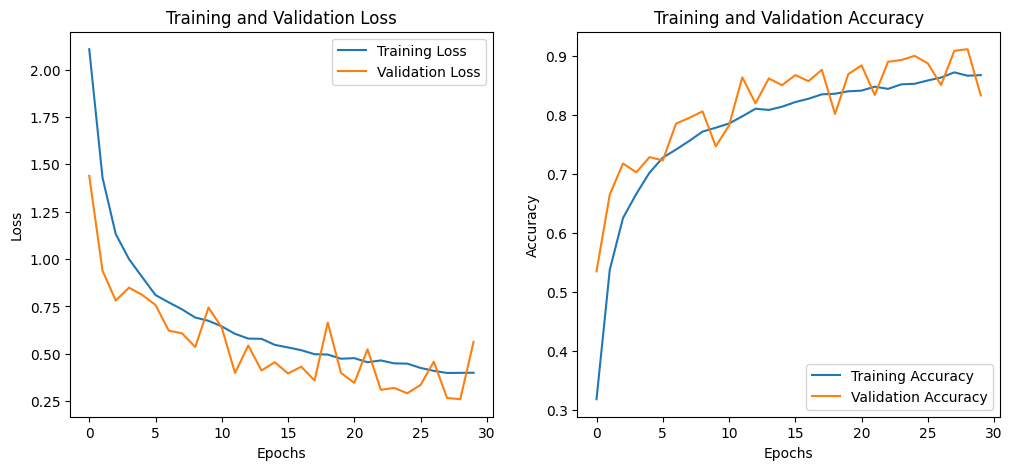

In [ ]:
# model visualization
visualize_model_performance(history)

In [ ]:
# model evalution
model.evaluate(test_generator)

129/129 [==============================] - 1s 7ms/step - loss: 0.5605 - accuracy: 0.8343


[0.5605137944221497, 0.8343037366867065]

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.52      0.94      0.67       199
                     Pepper__bell___healthy       0.87      0.99      0.93       295
                      Potato___Early_blight       0.57      1.00      0.73       200
                       Potato___Late_blight       0.87      0.55      0.67       200
                           Potato___healthy       0.85      0.73      0.79        30
                      Tomato_Bacterial_spot       0.94      0.91      0.92       425
                        Tomato_Early_blight       0.86      0.60      0.71       200
                         Tomato_Late_blight       0.87      0.78      0.82       381
                           Tomato_Leaf_Mold       0.85      0.76      0.81       190
                  Tomato_Septoria_leaf_spot       0.74      0.80      0.77       354
Tomato_Spider_mites_Two_spotted_spider_mi

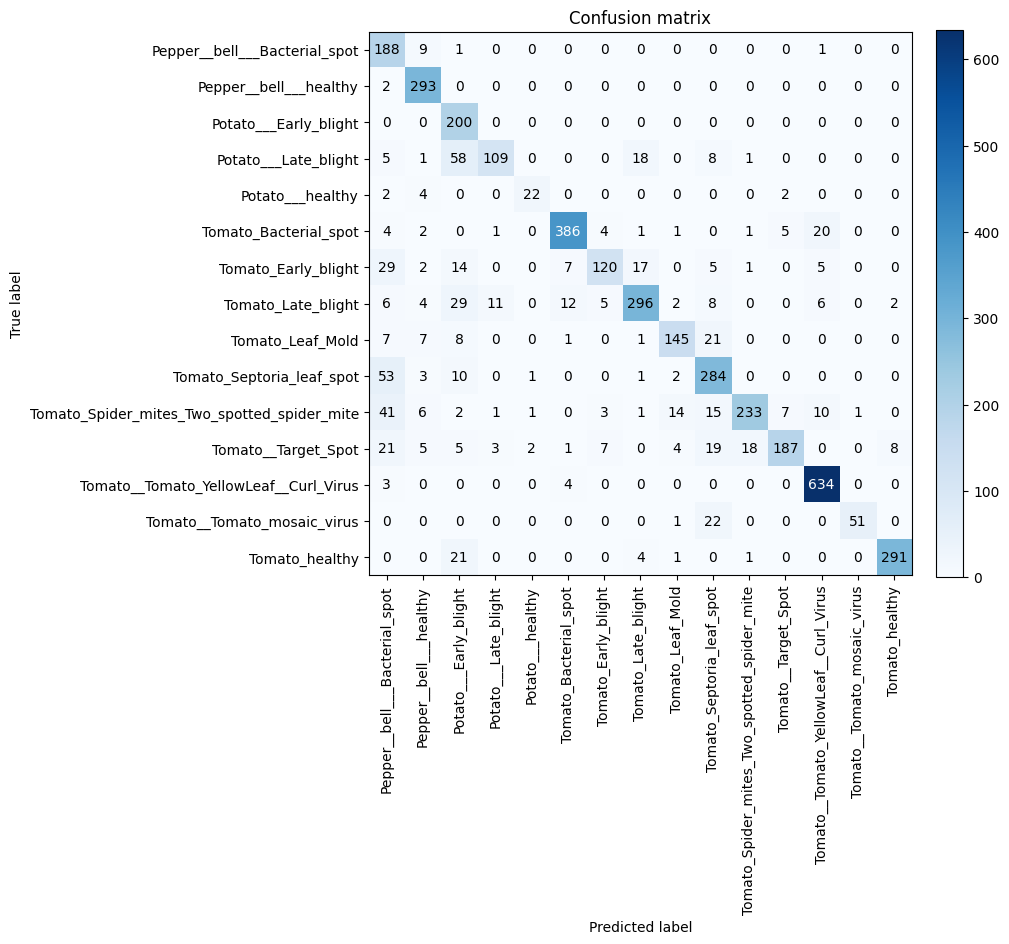

In [ ]:
# model evaluation and plotting
evaluate_and_plot(model, test_generator)

### the model appears to be over fitting, let add padding to the model

### padding the max pooling

### Model 1

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# define model architecture
model1 = Sequential()
model1.add(Conv2D(32, (3,3), activation = "relu",padding="same", input_shape = (64,64,3)))
model1.add(MaxPooling2D((2,2),padding="same"))

# another block
model1.add(Conv2D(64, (3,3), activation = "relu",padding="same"))
model1.add(MaxPooling2D((2,2),padding="same"))

# another block

model1.add(Conv2D(128, (3,3), activation = "relu",padding="same"))
model1.add(MaxPooling2D((2,2),padding="same"))

# flatten
model1.add(Flatten())

# add dense layers
model1.add(Dense(128, activation = "relu"))
model1.add(Dropout(0.5))

# output layer
model1.add(Dense(15,activation = "softmax"))

# compile the model
model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# check the summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0

In [ ]:
# defining model check point
check4 = ModelCheckpoint(os.path.join(model_filepath, "plant1.hdf5"), save_best_only=True,  verbose=1)

# early stopping
es4  = EarlyStopping(patience=4)


callback_list4 = [check4,es4]

In [ ]:
# training our model
history1 = model1.fit(train_generator, steps_per_epoch=train_generator.samples // 32,validation_data=test_generator, validation_steps=test_generator.samples//32, epochs=50 , callbacks=callback_list4)

Epoch 1/50
515/516 [============================>.] - ETA: 0s - loss: 1.9755 - accuracy: 0.3719
Epoch 1: val_loss improved from inf to 1.33641, saving model to D:/Ajala ai\plant44.hdf5
516/516 [==============================] - 36s 70ms/step - loss: 1.9754 - accuracy: 0.3722 - val_loss: 1.3364 - val_accuracy: 0.5518
Epoch 2/50
516/516 [==============================] - ETA: 0s - loss: 1.3181 - accuracy: 0.5710
Epoch 2: val_loss improved from 1.33641 to 0.95781, saving model to D:/Ajala ai\plant44.hdf5
516/516 [==============================] - 13s 26ms/step - loss: 1.3181 - accuracy: 0.5710 - val_loss: 0.9578 - val_accuracy: 0.6741
Epoch 3/50
515/516 [============================>.] - ETA: 0s - loss: 1.1163 - accuracy: 0.6385
Epoch 3: val_loss improved from 0.95781 to 0.78936, saving model to D:/Ajala ai\plant44.hdf5
516/516 [==============================] - 13s 26ms/step - loss: 1.1163 - accuracy: 0.6386 - val_loss: 0.7894 - val_accuracy: 0.7244
Epoch 4/50
515/516 [==================

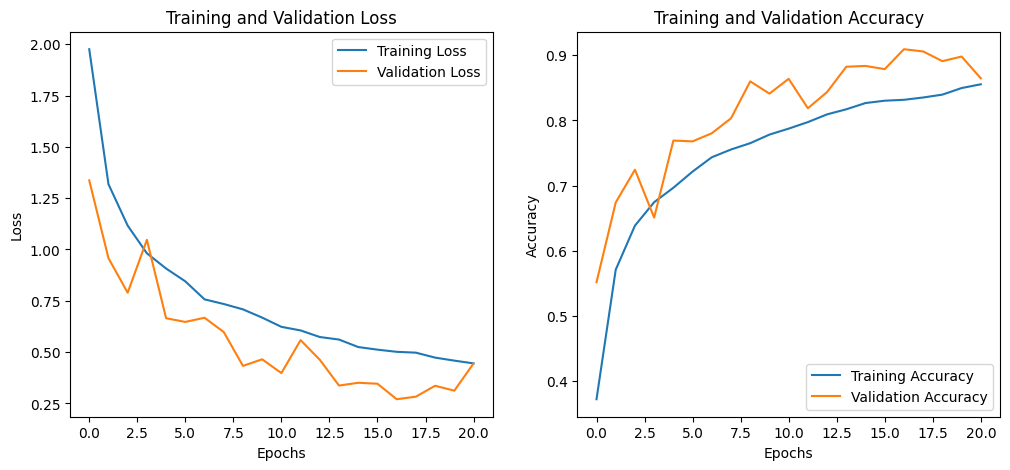

In [ ]:
# model visualization
visualize_model_performance(history1)

In [ ]:
# model evaluation
model1.evaluate(test_generator)

129/129 [==============================] - 1s 9ms/step - loss: 0.4448 - accuracy: 0.8644


[0.44480031728744507, 0.8643862009048462]

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.76      0.91      0.83       199
                     Pepper__bell___healthy       0.88      0.99      0.93       295
                      Potato___Early_blight       0.68      0.99      0.81       200
                       Potato___Late_blight       0.93      0.57      0.71       200
                           Potato___healthy       1.00      0.37      0.54        30
                      Tomato_Bacterial_spot       0.95      0.92      0.93       425
                        Tomato_Early_blight       0.66      0.81      0.73       200
                         Tomato_Late_blight       0.83      0.79      0.81       381
                           Tomato_Leaf_Mold       0.83      0.91      0.86       190
                  Tomato_Septoria_leaf_spot       0.92      0.78      0.85       354
Tomato_Spider_mites_Two_spotted_spider_mi

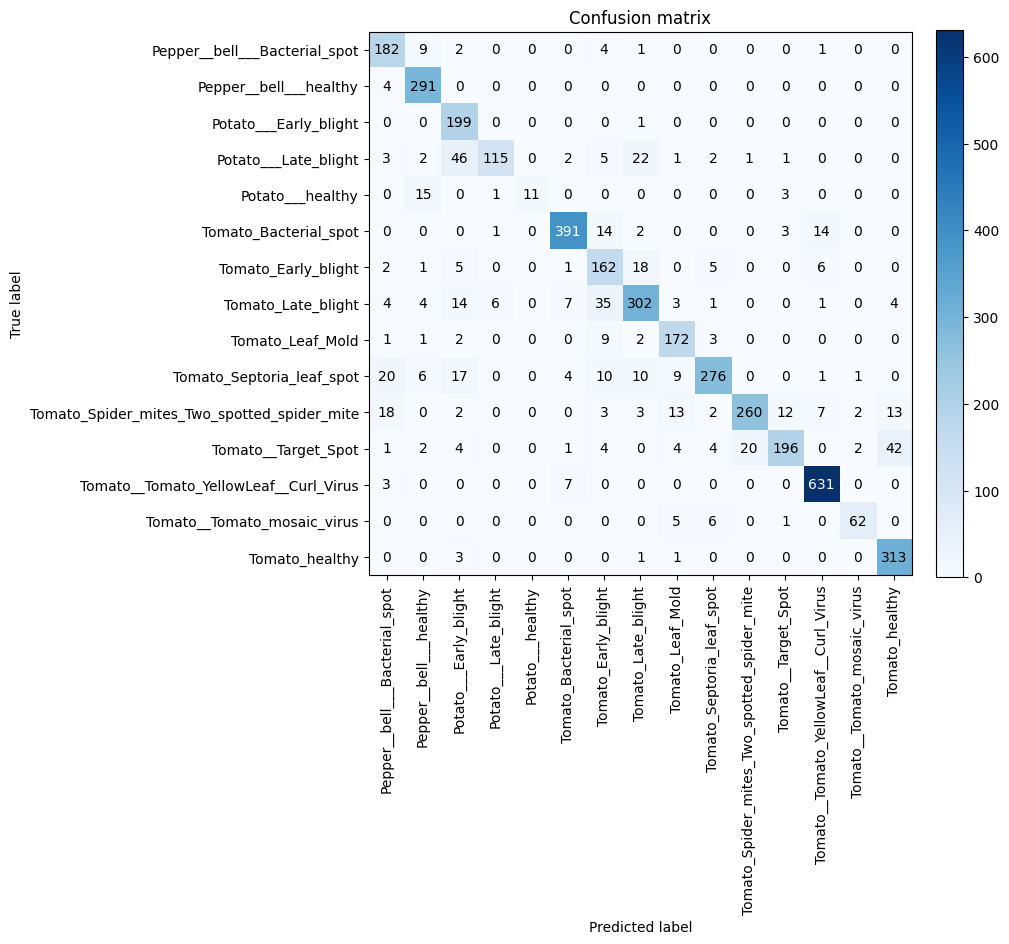

In [ ]:
# model prediction and evaluation
evaluate_and_plot(model1, test_generator)

 The the padding the convolution layer  improve the perfromance of the model from 84 to 86%

### Model 2

### Increasing the convolutional layers to 4  


In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# define model architecture
model2 = Sequential()
model2.add(Conv2D(32, (3,3), activation = "relu",padding="same", input_shape = (64,64,3)))
model2.add(MaxPooling2D((2,2),padding="same"))

# another block
model2.add(Conv2D(64, (3,3), activation = "relu",padding="same"))
model2.add(MaxPooling2D((2,2),padding="same"))

# another block

model2.add(Conv2D(128, (3,3), activation = "relu",padding="same"))
model2.add(MaxPooling2D((2,2),padding="same"))
# Add another Conv2D layer with 256 filters and a 3x3 kernel size, using ReLU activation
model2.add(Conv2D(256, (3, 3), activation='relu',padding="same"))
# Add another MaxPooling2D layer
model2.add(MaxPooling2D((2,2),padding="same"))

# flatten
model2.add(Flatten())

# add dense layers
model2.add(Dense(128, activation = "relu"))
model2.add(Dropout(0.5))


# output layer
model2.add(Dense(15,activation = "softmax"))

# compile the model
model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# check the summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0

In [ ]:
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant2.hdf5"), save_best_only=True,  verbose=1)

# early stopping
es2  = EarlyStopping(patience=4)


callback_list = [check2,es2]

In [ ]:
history2 = model2.fit(train_generator, steps_per_epoch=train_generator.samples // 32,validation_data=test_generator, validation_steps=test_generator.samples//32, epochs=50 , callbacks=callback_list)

Epoch 1/50
514/516 [============================>.] - ETA: 0s - loss: 2.1838 - accuracy: 0.2792
Epoch 1: val_loss improved from inf to 1.61894, saving model to D:/Ajala ai\plant6.hdf5
516/516 [==============================] - 14s 26ms/step - loss: 2.1817 - accuracy: 0.2800 - val_loss: 1.6189 - val_accuracy: 0.4626
Epoch 2/50
516/516 [==============================] - ETA: 0s - loss: 1.4637 - accuracy: 0.5237
Epoch 2: val_loss improved from 1.61894 to 0.97052, saving model to D:/Ajala ai\plant6.hdf5
516/516 [==============================] - 13s 26ms/step - loss: 1.4637 - accuracy: 0.5237 - val_loss: 0.9705 - val_accuracy: 0.6707
Epoch 3/50
515/516 [============================>.] - ETA: 0s - loss: 1.1281 - accuracy: 0.6323
Epoch 3: val_loss improved from 0.97052 to 0.86749, saving model to D:/Ajala ai\plant6.hdf5
516/516 [==============================] - 13s 26ms/step - loss: 1.1284 - accuracy: 0.6322 - val_loss: 0.8675 - val_accuracy: 0.7075
Epoch 4/50
514/516 [=====================

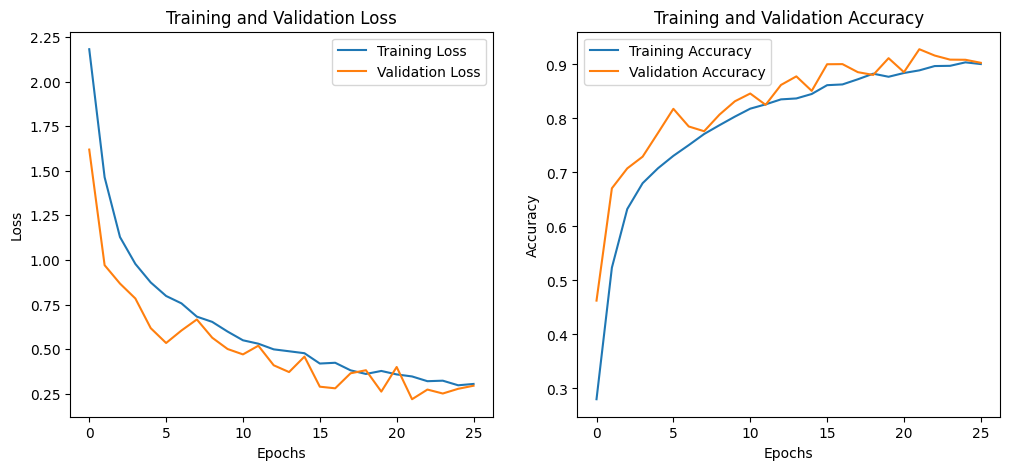

In [ ]:
visualize_model_performance(history2)

In [ ]:
model2.evaluate(test_generator)

129/129 [==============================] - 1s 10ms/step - loss: 0.2928 - accuracy: 0.9037


[0.29283180832862854, 0.9036875367164612]

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.91      0.92      0.91       199
                     Pepper__bell___healthy       0.93      1.00      0.96       295
                      Potato___Early_blight       0.94      0.97      0.96       200
                       Potato___Late_blight       0.95      0.77      0.85       200
                           Potato___healthy       0.88      0.77      0.82        30
                      Tomato_Bacterial_spot       0.96      0.82      0.88       425
                        Tomato_Early_blight       0.63      0.96      0.76       200
                         Tomato_Late_blight       0.93      0.83      0.88       381
                           Tomato_Leaf_Mold       0.87      0.93      0.90       190
                  Tomato_Septoria_leaf_spot       0.92      0.86      0.89       354
Tomato_Spider_mites_Two_spotted_spider_mi

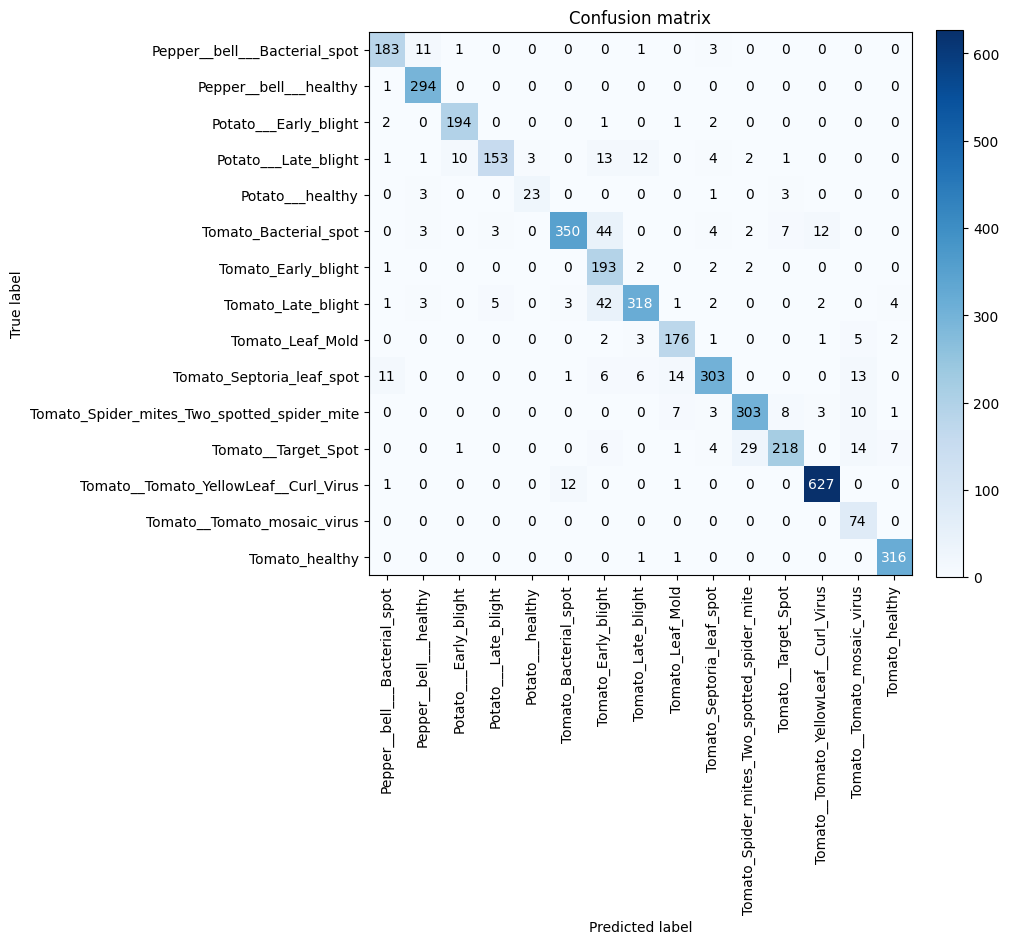

In [ ]:
# evalute and plot
evaluate_and_plot(model2, test_generator)

increasing the number of convolutional layers from three to four improved the performance of our model increase the performance of our model form accuracy of 86% to 90 %

### Model 3

####  Effect of five convolutional layers on the performance our model

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# define model architecture
model3 = Sequential()
model3.add(Conv2D(32, (3,3), activation = "relu",padding="same", input_shape = (64,64,3)))
model3.add(MaxPooling2D((2,2),padding="same"))

# another block
model3.add(Conv2D(64, (3,3), activation = "relu",padding="same"))
model3.add(MaxPooling2D((2,2),padding="same"))

# another block

model3.add(Conv2D(128, (3,3), activation = "relu",padding="same"))
model3.add(MaxPooling2D((2,2),padding="same"))

model3.add(Conv2D(128, (3,3), activation = "relu",padding="same"))
model3.add(MaxPooling2D((2,2),padding="same"))

# Add another Conv2D layer with 256 filters and a 3x3 kernel size, using ReLU activation
model3.add(Conv2D(256, (3, 3), activation='relu',padding="same"))
# Add another MaxPooling2D layer
model3.add(MaxPooling2D((2,2),padding="same"))

# flatten
model3.add(Flatten())

# add dense layers
model3.add(Dense(128, activation = "relu"))
model3.add(Dropout(0.5))


# output layer
model3.add(Dense(15,activation = "softmax"))

# compile the model
model3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# check the summary
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 8, 8, 128)        

In [ ]:
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant3.hdf5"), save_best_only=True,  verbose=1)

# early stopping
es2  = EarlyStopping(patience=4)


callback_list = [check2,es2]

In [ ]:
history3 = model3.fit(train_generator, steps_per_epoch=train_generator.samples // 32,validation_data=test_generator, validation_steps=test_generator.samples//32, epochs=50 , callbacks=callback_list)

Epoch 1/50
516/516 [==============================] - ETA: 0s - loss: 2.2278 - accuracy: 0.2686
Epoch 1: val_loss improved from inf to 1.96010, saving model to D:/Ajala ai\plant5.hdf5
516/516 [==============================] - 15s 28ms/step - loss: 2.2278 - accuracy: 0.2686 - val_loss: 1.9601 - val_accuracy: 0.3716
Epoch 2/50
515/516 [============================>.] - ETA: 0s - loss: 1.5349 - accuracy: 0.5008
Epoch 2: val_loss improved from 1.96010 to 1.31104, saving model to D:/Ajala ai\plant5.hdf5
516/516 [==============================] - 14s 26ms/step - loss: 1.5350 - accuracy: 0.5008 - val_loss: 1.3110 - val_accuracy: 0.5581
Epoch 3/50
515/516 [============================>.] - ETA: 0s - loss: 1.1541 - accuracy: 0.6221
Epoch 3: val_loss improved from 1.31104 to 0.96406, saving model to D:/Ajala ai\plant5.hdf5
516/516 [==============================] - 13s 26ms/step - loss: 1.1544 - accuracy: 0.6220 - val_loss: 0.9641 - val_accuracy: 0.6748
Epoch 4/50
516/516 [=====================

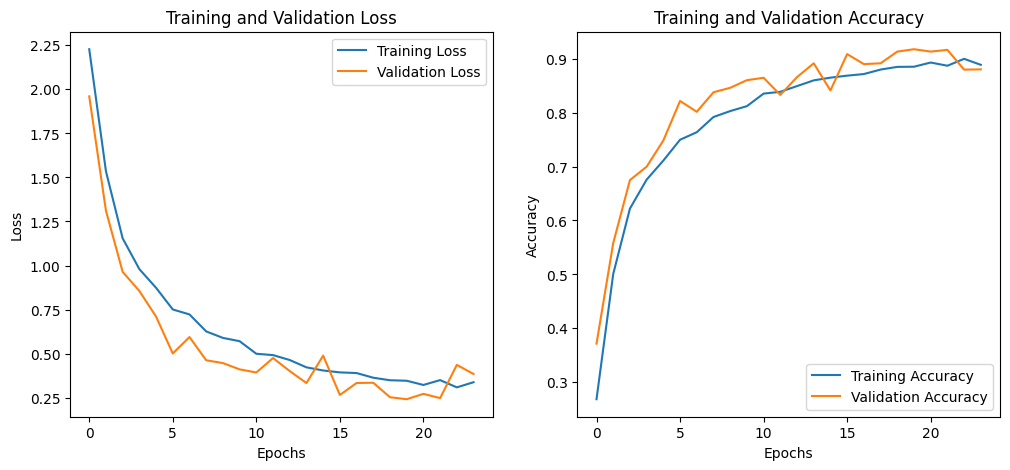

In [ ]:
visualize_model_performance(history3)

In [ ]:
# evalaute our model
model3.evaluate(test_generator)

129/129 [==============================] - 1s 9ms/step - loss: 0.3848 - accuracy: 0.8804


[0.38479259610176086, 0.8803978562355042]

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.79      0.89      0.83       199
                     Pepper__bell___healthy       0.83      1.00      0.91       295
                      Potato___Early_blight       0.85      0.99      0.92       200
                       Potato___Late_blight       0.95      0.70      0.81       200
                           Potato___healthy       0.85      0.57      0.68        30
                      Tomato_Bacterial_spot       0.91      0.94      0.92       425
                        Tomato_Early_blight       0.70      0.94      0.80       200
                         Tomato_Late_blight       0.90      0.82      0.86       381
                           Tomato_Leaf_Mold       0.81      0.92      0.86       190
                  Tomato_Septoria_leaf_spot       0.95      0.72      0.82       354
Tomato_Spider_mites_Two_spotted_spider_mi

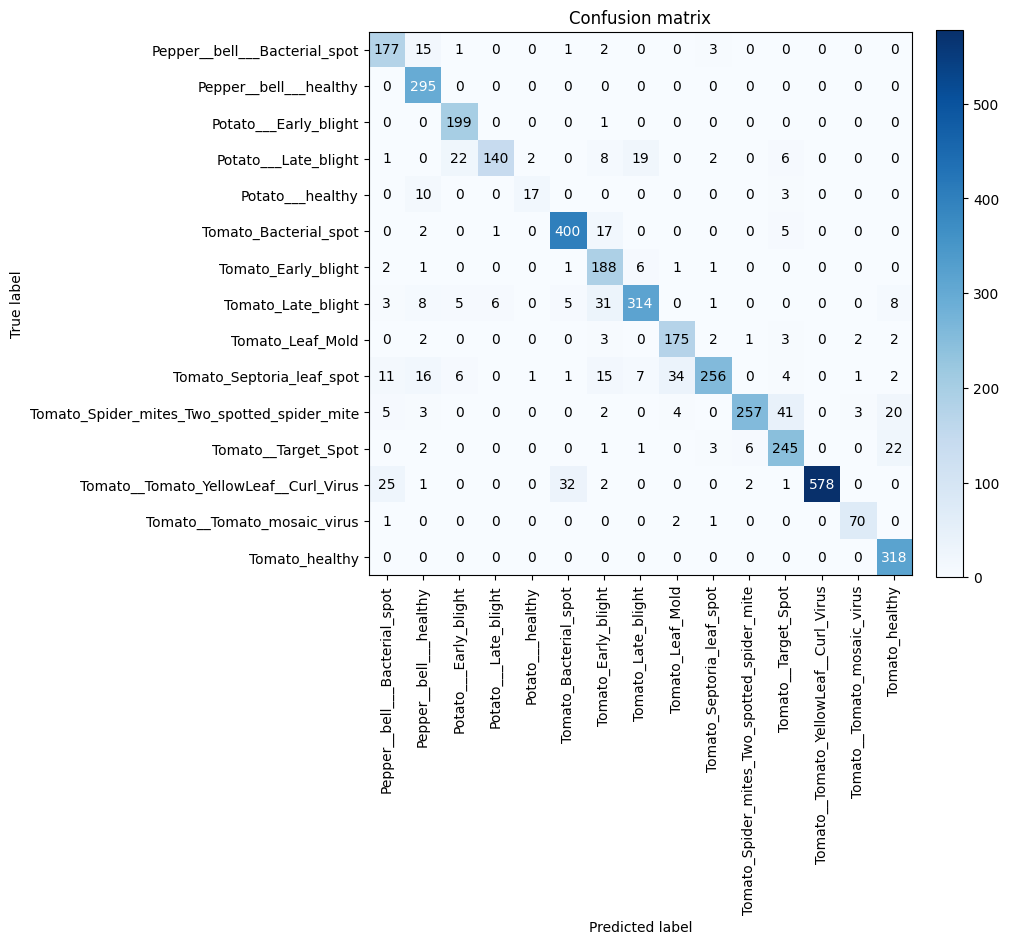

In [ ]:
# model evaluatuion and plotting
evaluate_and_plot(model3, test_generator)

Adding a fifth convolutional layer did not result in further performance improvement for our model. The previous model, consisting of four convolutional layers with an accuracy of 90%, outperformed the model with five convolutional layers, which achieved an accuracy of 80%.

#### Effect of different optimizers on the best model thus far (Model 2)

Based on the preceding analysis, the model with four convolutional layers (Model2) exhibited the best performance. Therefore, we will subject this model to various optimizers to explore the potential for further performance enhancement.

 ### Model 4

 ### RMSprop

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# define model architecture
model4 = Sequential()
model4.add(Conv2D(32, (3,3), activation = "relu",padding="same", input_shape = (64,64,3)))
model4.add(MaxPooling2D((2,2),padding="same"))

# another block
model4.add(Conv2D(64, (3,3), activation = "relu",padding="same"))
model4.add(MaxPooling2D((2,2),padding="same"))

# another block

model4.add(Conv2D(128, (3,3), activation = "relu",padding="same"))
model4.add(MaxPooling2D((2,2),padding="same"))
# Add another Conv2D layer with 256 filters and a 3x3 kernel size, using ReLU activation
model4.add(Conv2D(256, (3, 3), activation='relu',padding="same"))
# Add another MaxPooling2D layer
model4.add(MaxPooling2D((2,2),padding="same"))

# flatten
model4.add(Flatten())

# add dense layers
model4.add(Dense(128, activation = "relu"))
model4.add(Dropout(0.5))


# output layer
model4.add(Dense(15,activation = "softmax"))

# compile the model
model4.compile(optimizer=RMSprop(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# check the summary
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

In [ ]:
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant4.hdf5"), save_best_only=True,  verbose=1)

# early stopping
es2  = EarlyStopping(patience=4)


callback_list = [check2,es2]

In [ ]:
history4 = model4.fit(train_generator, steps_per_epoch=train_generator.samples // 32,validation_data=test_generator, validation_steps=test_generator.samples//32, epochs=50 , callbacks=callback_list)

Epoch 1/50
515/516 [============================>.] - ETA: 0s - loss: 2.2406 - accuracy: 0.2609
Epoch 1: val_loss improved from inf to 1.72878, saving model to D:/Ajala ai\plant8.hdf5
516/516 [==============================] - 25s 46ms/step - loss: 2.2399 - accuracy: 0.2610 - val_loss: 1.7288 - val_accuracy: 0.4624
Epoch 2/50
515/516 [============================>.] - ETA: 0s - loss: 1.5773 - accuracy: 0.4857
Epoch 2: val_loss improved from 1.72878 to 1.27770, saving model to D:/Ajala ai\plant8.hdf5
516/516 [==============================] - 24s 46ms/step - loss: 1.5772 - accuracy: 0.4857 - val_loss: 1.2777 - val_accuracy: 0.5796
Epoch 3/50
516/516 [==============================] - ETA: 0s - loss: 1.2278 - accuracy: 0.5977
Epoch 3: val_loss improved from 1.27770 to 0.93719, saving model to D:/Ajala ai\plant8.hdf5
516/516 [==============================] - 56s 109ms/step - loss: 1.2278 - accuracy: 0.5977 - val_loss: 0.9372 - val_accuracy: 0.6780
Epoch 4/50
516/516 [====================

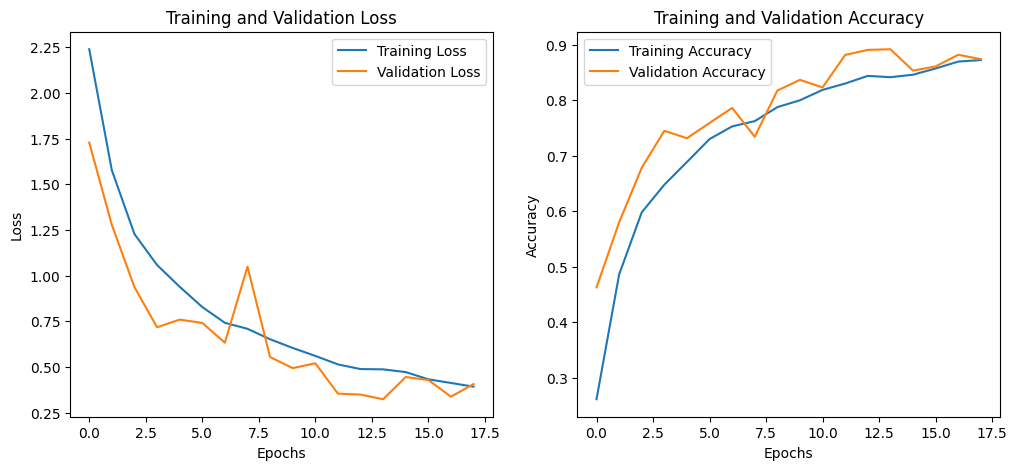

In [ ]:
visualize_model_performance(history4)

In [ ]:
model4.evaluate(test_generator)

129/129 [==============================] - 2s 15ms/step - loss: 0.4072 - accuracy: 0.8734


[0.40721192955970764, 0.8733624219894409]

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.83      0.87      0.85       199
                     Pepper__bell___healthy       0.90      1.00      0.95       295
                      Potato___Early_blight       0.82      0.96      0.89       200
                       Potato___Late_blight       0.97      0.59      0.74       200
                           Potato___healthy       0.87      0.67      0.75        30
                      Tomato_Bacterial_spot       0.94      0.94      0.94       425
                        Tomato_Early_blight       0.64      0.81      0.72       200
                         Tomato_Late_blight       0.90      0.70      0.79       381
                           Tomato_Leaf_Mold       0.82      0.96      0.89       190
                  Tomato_Septoria_leaf_spot       0.85      0.88      0.87       354
Tomato_Spider_mites_Two_spotted_spider_mi

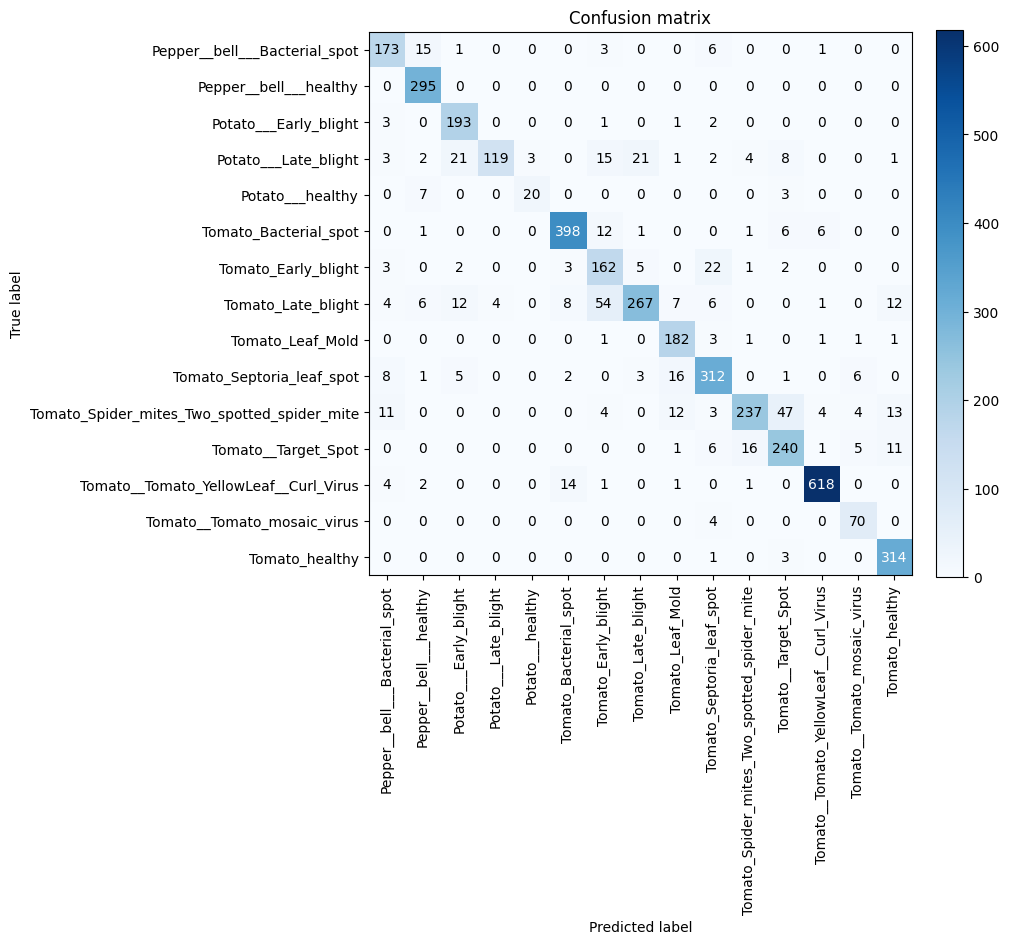

In [ ]:
# evalute and predict
evaluate_and_plot(model4, test_generator)

Our model's performance did not see improvement with RMSprop; however, Adam optimizer outperformed RMSprop.

### Model5

### SGD

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# define model architecture
model5 = Sequential()
model5.add(Conv2D(32, (3,3), activation = "relu",padding="same", input_shape = (64,64,3)))
model5.add(MaxPooling2D((2,2),padding="same"))

# another block
model5.add(Conv2D(64, (3,3), activation = "relu",padding="same"))
model5.add(MaxPooling2D((2,2),padding="same"))

# another block

model5.add(Conv2D(128, (3,3), activation = "relu",padding="same"))
model5.add(MaxPooling2D((2,2),padding="same"))

# Add another Conv2D layer with 256 filters and a 3x3 kernel size, using ReLU activation
model5.add(Conv2D(256, (3, 3), activation='relu',padding="same"))
model5.add(MaxPooling2D((2,2),padding="same"))

# flattem
model5.add(Flatten())

# add dense layers
model5.add(Dense(128, activation = "relu"))
model5.add(Dropout(0.5))

# output layer
# output layer
model5.add(Dense(15,activation = "softmax"))

# compile the model
model5.compile(optimizer=SGD(), loss="categorical_crossentropy", metrics=["accuracy"])

# check the summary
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

In [ ]:
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant5.hdf5"), save_best_only=True,  verbose=1)

# early stopping
es2  = EarlyStopping(patience=4)


callback_list = [check2,es2]

In [ ]:
history5 = model5.fit(train_generator, steps_per_epoch=train_generator.samples // 32,validation_data=test_generator, validation_steps=test_generator.samples//32, epochs=30 , callbacks=callback_list)

Epoch 1/30
516/516 [==============================] - ETA: 0s - loss: 2.6027 - accuracy: 0.1467
Epoch 1: val_loss improved from inf to 2.55063, saving model to D:/Ajala ai\plant9.hdf5
516/516 [==============================] - 83s 160ms/step - loss: 2.6027 - accuracy: 0.1467 - val_loss: 2.5506 - val_accuracy: 0.1553
Epoch 2/30
515/516 [============================>.] - ETA: 0s - loss: 2.4550 - accuracy: 0.2025
Epoch 2: val_loss improved from 2.55063 to 2.34017, saving model to D:/Ajala ai\plant9.hdf5
516/516 [==============================] - 24s 46ms/step - loss: 2.4546 - accuracy: 0.2027 - val_loss: 2.3402 - val_accuracy: 0.2417
Epoch 3/30
516/516 [==============================] - ETA: 0s - loss: 2.2856 - accuracy: 0.2721
Epoch 3: val_loss improved from 2.34017 to 2.08798, saving model to D:/Ajala ai\plant9.hdf5
516/516 [==============================] - 24s 46ms/step - loss: 2.2856 - accuracy: 0.2721 - val_loss: 2.0880 - val_accuracy: 0.3784
Epoch 4/30
515/516 [====================

In [ ]:
model5.evaluate(test_generator)

129/129 [==============================] - 2s 13ms/step - loss: 0.4418 - accuracy: 0.8481


[0.44176605343818665, 0.8481319546699524]

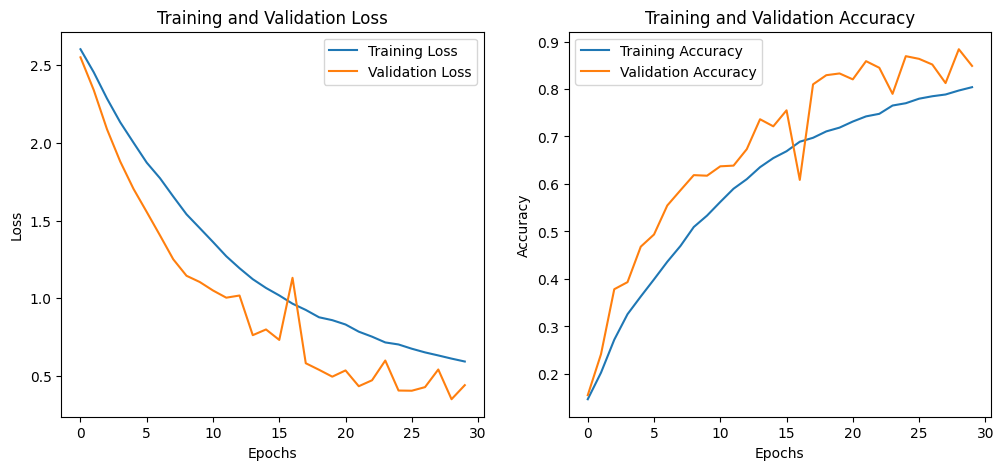

In [ ]:
visualize_model_performance(history5)

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.76      0.89      0.82       199
                     Pepper__bell___healthy       0.85      0.98      0.91       295
                      Potato___Early_blight       0.86      0.95      0.91       200
                       Potato___Late_blight       0.80      0.87      0.83       200
                           Potato___healthy       0.74      0.57      0.64        30
                      Tomato_Bacterial_spot       0.97      0.82      0.89       425
                        Tomato_Early_blight       0.84      0.58      0.69       200
                         Tomato_Late_blight       0.90      0.79      0.84       381
                           Tomato_Leaf_Mold       0.98      0.64      0.77       190
                  Tomato_Septoria_leaf_spot       0.84      0.69      0.76       354
Tomato_Spider_mites_Two_spotted_spider_mi

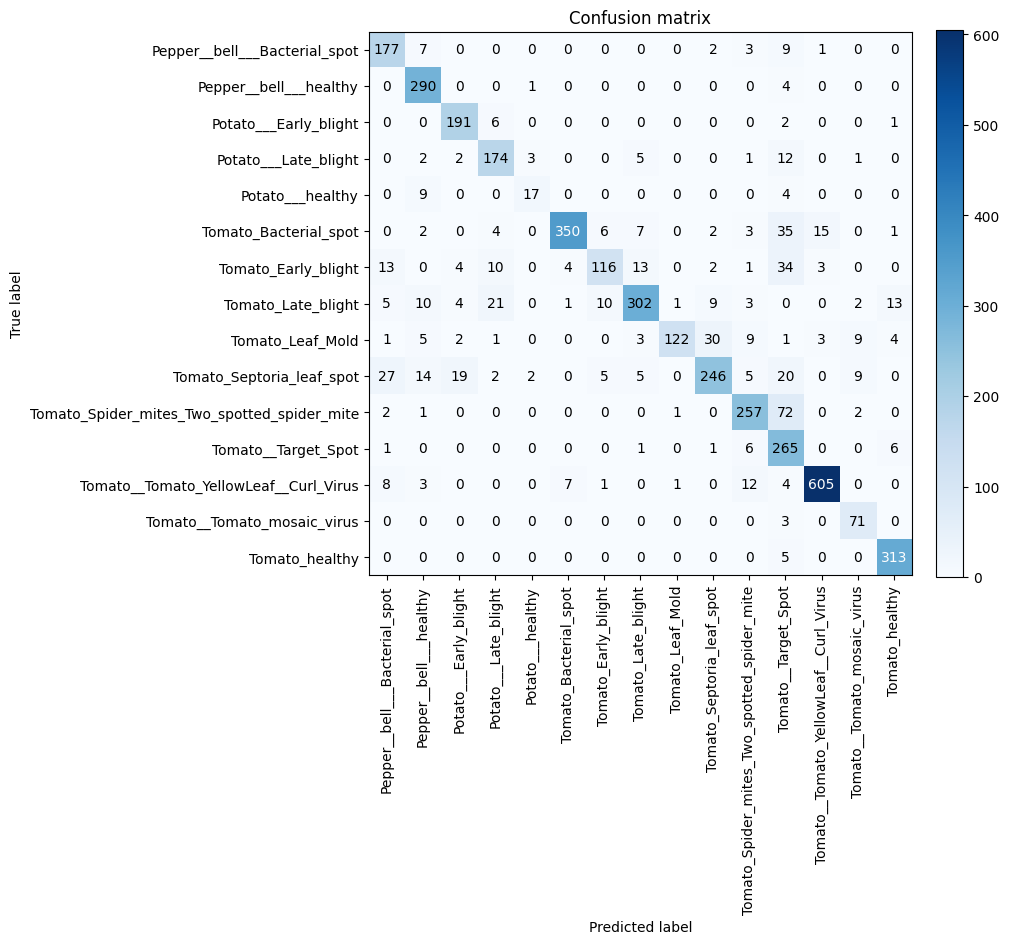

In [ ]:
# evalute, predict and visualize
evaluate_and_plot(model5, test_generator)#

### compared to adam optimizer the performance of the model was not improved

### Model 6

### Adamax

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# define model architecture
model6 = Sequential()
model6.add(Conv2D(32, (3,3), activation = "relu",padding="same", input_shape = (64,64,3)))
model6.add(MaxPooling2D((2,2),padding="same"))

# another block
model6.add(Conv2D(64, (3,3), activation = "relu",padding="same"))
model6.add(MaxPooling2D((2,2),padding="same"))

# another block

model6.add(Conv2D(128, (3,3), activation = "relu",padding="same"))
model6.add(MaxPooling2D((2,2),padding="same"))

# Add another Conv2D layer with 256 filters and a 3x3 kernel size, using ReLU activation
model6.add(Conv2D(256, (3, 3), activation='relu',padding="same"))
model6.add(MaxPooling2D((2,2),padding="same"))

# flatten
model6.add(Flatten())

# add dense layers
model6.add(Dense(128, activation = "relu"))
model6.add(Dropout(0.5))

# output layer
model6.add(Dense(15,activation = "softmax"))

# compile the model
model6.compile(optimizer=Adamax(), loss="categorical_crossentropy", metrics=["accuracy"])

# check the summary
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

In [ ]:
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant6.hdf5"), save_best_only=True,  verbose=1)

# early stopping
es2  = EarlyStopping(patience=4)


callback_list = [check2,es2]

In [ ]:
history6 = model6.fit(train_generator, steps_per_epoch=train_generator.samples // 32,validation_data=test_generator, validation_steps=test_generator.samples//32, epochs=50 , callbacks=callback_list)

Epoch 1/50
516/516 [==============================] - ETA: 0s - loss: 2.3859 - accuracy: 0.2227
Epoch 1: val_loss improved from inf to 1.95507, saving model to D:/Ajala ai\plant10.hdf5
516/516 [==============================] - 82s 157ms/step - loss: 2.3859 - accuracy: 0.2227 - val_loss: 1.9551 - val_accuracy: 0.3831
Epoch 2/50
516/516 [==============================] - ETA: 0s - loss: 1.7863 - accuracy: 0.4297
Epoch 2: val_loss improved from 1.95507 to 1.37708, saving model to D:/Ajala ai\plant10.hdf5
516/516 [==============================] - 23s 45ms/step - loss: 1.7863 - accuracy: 0.4297 - val_loss: 1.3771 - val_accuracy: 0.5564
Epoch 3/50
516/516 [==============================] - ETA: 0s - loss: 1.4026 - accuracy: 0.5481
Epoch 3: val_loss improved from 1.37708 to 1.25843, saving model to D:/Ajala ai\plant10.hdf5
516/516 [==============================] - 24s 46ms/step - loss: 1.4026 - accuracy: 0.5481 - val_loss: 1.2584 - val_accuracy: 0.5891
Epoch 4/50
516/516 [=================

516/516 [==============================] - 23s 45ms/step - loss: 0.3304 - accuracy: 0.8915 - val_loss: 0.4328 - val_accuracy: 0.8723


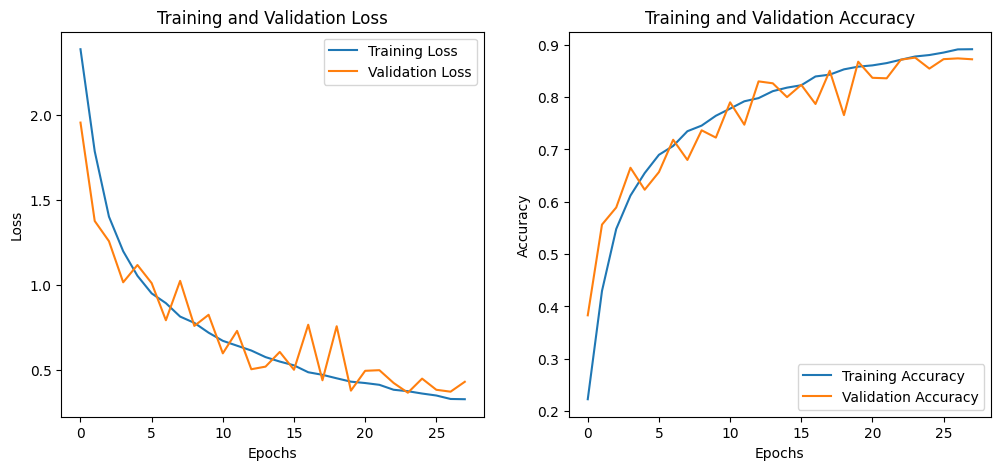

In [ ]:
visualize_model_performance(history6)

In [ ]:
model6.evaluate(test_generator)

129/129 [==============================] - 2s 14ms/step - loss: 0.4327 - accuracy: 0.8721


[0.43266239762306213, 0.8721494674682617]

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.78      0.93      0.85       199
                     Pepper__bell___healthy       0.84      0.99      0.91       295
                      Potato___Early_blight       0.94      0.90      0.92       200
                       Potato___Late_blight       0.96      0.66      0.78       200
                           Potato___healthy       0.76      0.73      0.75        30
                      Tomato_Bacterial_spot       0.98      0.80      0.88       425
                        Tomato_Early_blight       0.70      0.83      0.76       200
                         Tomato_Late_blight       0.92      0.81      0.86       381
                           Tomato_Leaf_Mold       0.92      0.90      0.91       190
                  Tomato_Septoria_leaf_spot       0.90      0.87      0.88       354
Tomato_Spider_mites_Two_spotted_spider_mi

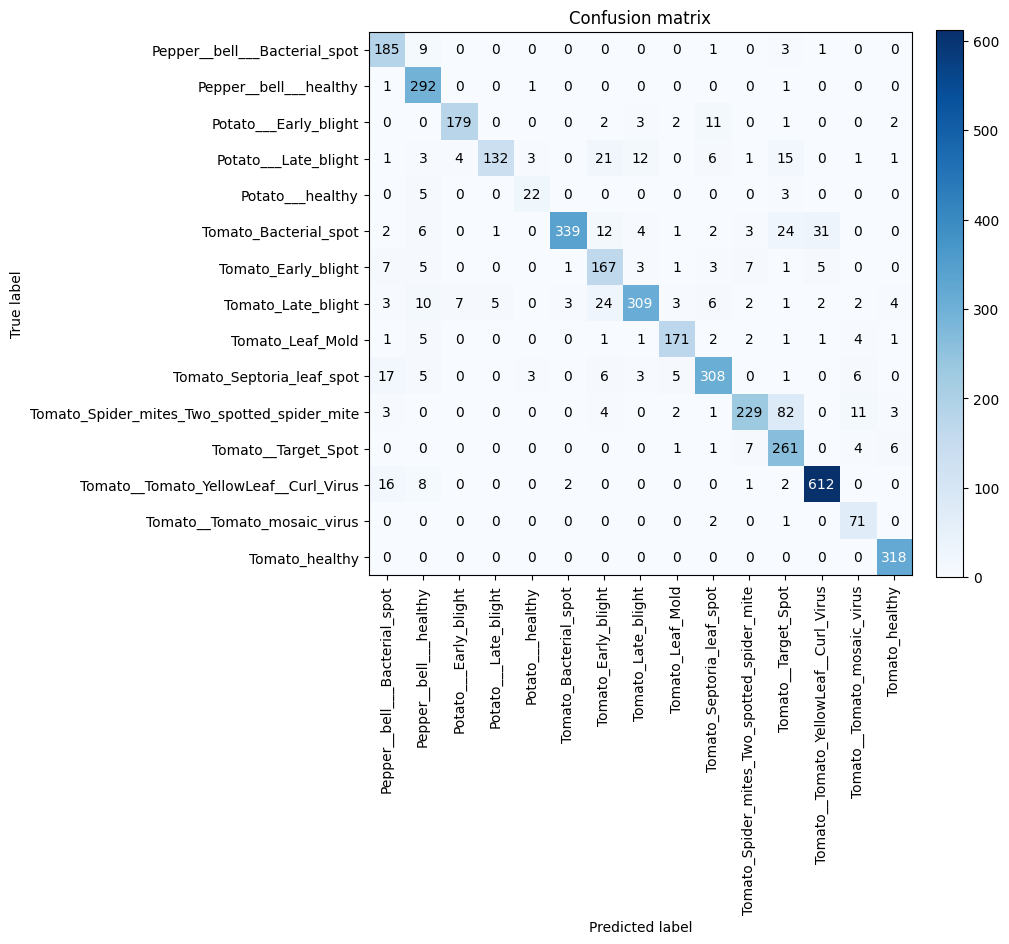

In [ ]:
# get the classification report and confusion matric
evaluate_and_plot(model6, test_generator)

Among the various optimizers used, the Adam optimizer demonstrated the best performance, followed by Adamax.

### visualizing the validation accuracy of different optimizer on the best custome model

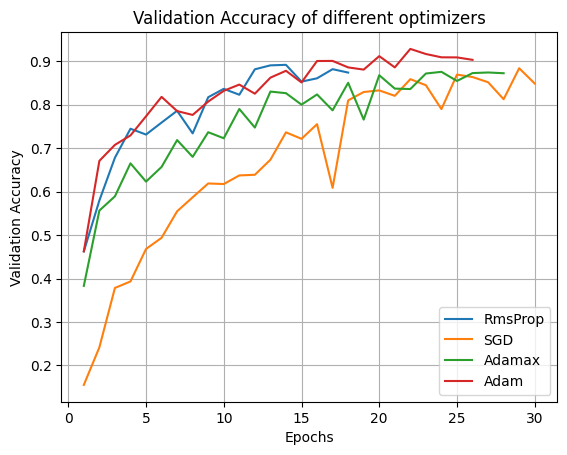

In [ ]:
# Define the training logs for each model
models_logs = {

    "RmsProp": [
        0.4624, 0.5796, 0.6780, 0.7446, 0.7312,
        0.7588, 0.7859, 0.7339, 0.8171, 0.8364,
        0.8228, 0.8813, 0.8904, 0.8916, 0.8530,
        0.8606, 0.8816, 0.8738
    ],
    "SGD": [  # Add the validation accuracy for SGD
        0.1553, 0.2417, 0.3784, 0.3933, 0.4680,
        0.4937, 0.5547, 0.5869, 0.6187, 0.6174,
        0.6372, 0.6387, 0.6733, 0.7363, 0.7214,
        0.7551, 0.6086, 0.8098, 0.8291, 0.8328,
        0.8203, 0.8586, 0.8447, 0.7898, 0.8691,
        0.8635, 0.8516, 0.8125, 0.8838, 0.8486
    ],
    "Adamax": [  # Add the validation accuracy for Adamax
        0.3831, 0.5564, 0.5891, 0.6650, 0.6230,
        0.6567, 0.7185, 0.6799, 0.7366, 0.7227,
        0.7900, 0.7473, 0.8301, 0.8264, 0.8000,
        0.8235, 0.7869, 0.8503, 0.7656, 0.8677,
        0.8369, 0.8359, 0.8716, 0.8755, 0.8545,
        0.8726, 0.8740, 0.8723
    ],
    "Adam": [
        # Add the validation accuracy for Adam
        0.4626, 0.6707, 0.7075, 0.7292, 0.7732,
        0.8179, 0.7852, 0.7764, 0.8071, 0.8318,
        0.8462, 0.8252, 0.8621, 0.8779, 0.8511,
        0.9004, 0.9006, 0.8857, 0.8806, 0.9116,
        0.8857, 0.9282, 0.9165, 0.9089, 0.9087,
        0.9031
    ],
}

# Find the maximum number of epochs among all models
max_epochs = max(len(val_acc) for val_acc in models_logs.values())

# Create x-axis values (epochs) based on the maximum number of epochs
epochs = list(range(1, max_epochs + 1))

# Plot the validation accuracy for each model up to the maximum number of epochs
for model_name, val_acc in models_logs.items():
    # If the model has fewer epochs, pad with NaN values to match the maximum number of epochs
    val_acc_padded = val_acc + [float('nan')] * (max_epochs - len(val_acc))
    plt.plot(epochs, val_acc_padded, label=model_name)

# Customize the plot
plt.title("Validation Accuracy of different optimizers")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

The validation accuracy plot reveals distinct convergence patterns among these optimizers. The Adam optimizer exhibited rapid convergence, surpassing 80% accuracy within the initial epochs and continuing to improve. In contrast, RMSprop and Adamax showed gradual convergence, eventually plateauing after a few epochs without achieving the same level of accuracy as the Adam optimizer. The SGD optimizer demonstrated a less stable convergence pattern, suggesting that it may necessitate hyperparameter fine-tuning to realize its full convergence potential

### Exploring Other Hyperparameters tunning to the Enhance Performance of our best model (Model 2)

### Model 7

### 0.0001

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# define model architecture
model7 = Sequential()
model7.add(Conv2D(32, (3,3), activation = "relu",padding="same", input_shape = (64,64,3)))
model7.add(MaxPooling2D((2,2),padding="same"))

# another block
model7.add(Conv2D(64, (3,3), activation = "relu",padding="same"))
model7.add(MaxPooling2D((2,2),padding="same"))

# another block

model7.add(Conv2D(128, (3,3), activation = "relu",padding="same"))
model7.add(MaxPooling2D((2,2),padding="same"))


# Add another Conv2D layer with 256 filters and a 3x3 kernel size, using ReLU activation
model7.add(Conv2D(256, (3, 3), activation='relu',padding="same"))
model7.add(MaxPooling2D((2,2),padding="same"))


# flatten
model7.add(Flatten())

# add dense layers
model7.add(Dense(128, activation = "relu"))
model7.add(Dropout(0.5))


# output layer
model7.add(Dense(15,activation = "softmax"))

# compile the model
model7.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# check the summary
model7.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

In [ ]:
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant7.hdf5"), save_best_only=True,  verbose=1)

# early stopping
es2  = EarlyStopping(patience=4)


callback_list = [check2,es2]

In [ ]:
history7 = model7.fit(train_generator, steps_per_epoch=train_generator.samples // 32,validation_data=test_generator, validation_steps=test_generator.samples//32, epochs=50 , callbacks=callback_list)

Epoch 1/50
516/516 [==============================] - ETA: 0s - loss: 2.3687 - accuracy: 0.2269
Epoch 1: val_loss improved from inf to 1.91212, saving model to D:/Ajala ai\plant14.hdf5
516/516 [==============================] - 25s 47ms/step - loss: 2.3687 - accuracy: 0.2269 - val_loss: 1.9121 - val_accuracy: 0.3982
Epoch 2/50
515/516 [============================>.] - ETA: 0s - loss: 1.8697 - accuracy: 0.4125
Epoch 2: val_loss improved from 1.91212 to 1.46128, saving model to D:/Ajala ai\plant14.hdf5
516/516 [==============================] - 24s 46ms/step - loss: 1.8696 - accuracy: 0.4125 - val_loss: 1.4613 - val_accuracy: 0.5479
Epoch 3/50
515/516 [============================>.] - ETA: 0s - loss: 1.5812 - accuracy: 0.5011
Epoch 3: val_loss improved from 1.46128 to 1.20069, saving model to D:/Ajala ai\plant14.hdf5
516/516 [==============================] - 23s 45ms/step - loss: 1.5816 - accuracy: 0.5012 - val_loss: 1.2007 - val_accuracy: 0.6121
Epoch 4/50
516/516 [==================

In [ ]:
model7.evaluate(test_generator)

129/129 [==============================] - 2s 13ms/step - loss: 0.7977 - accuracy: 0.7310


[0.7977462410926819, 0.7309558391571045]

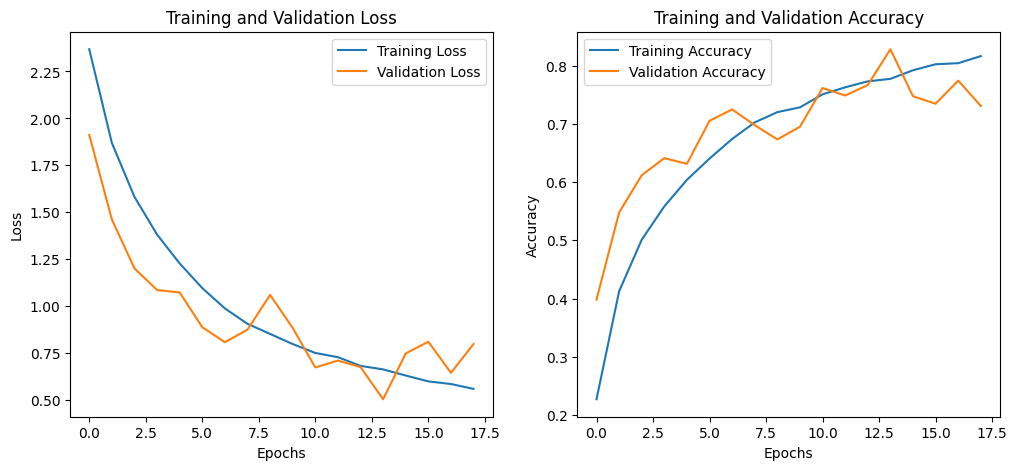

In [ ]:
visualize_model_performance(history7)

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.60      0.83      0.70       199
                     Pepper__bell___healthy       0.81      0.97      0.88       295
                      Potato___Early_blight       0.93      0.90      0.91       200
                       Potato___Late_blight       0.71      0.82      0.76       200
                           Potato___healthy       0.50      0.13      0.21        30
                      Tomato_Bacterial_spot       0.89      0.84      0.86       425
                        Tomato_Early_blight       0.61      0.74      0.67       200
                         Tomato_Late_blight       0.83      0.75      0.79       381
                           Tomato_Leaf_Mold       0.89      0.74      0.81       190
                  Tomato_Septoria_leaf_spot       0.86      0.67      0.75       354
Tomato_Spider_mites_Two_spotted_spider_mi

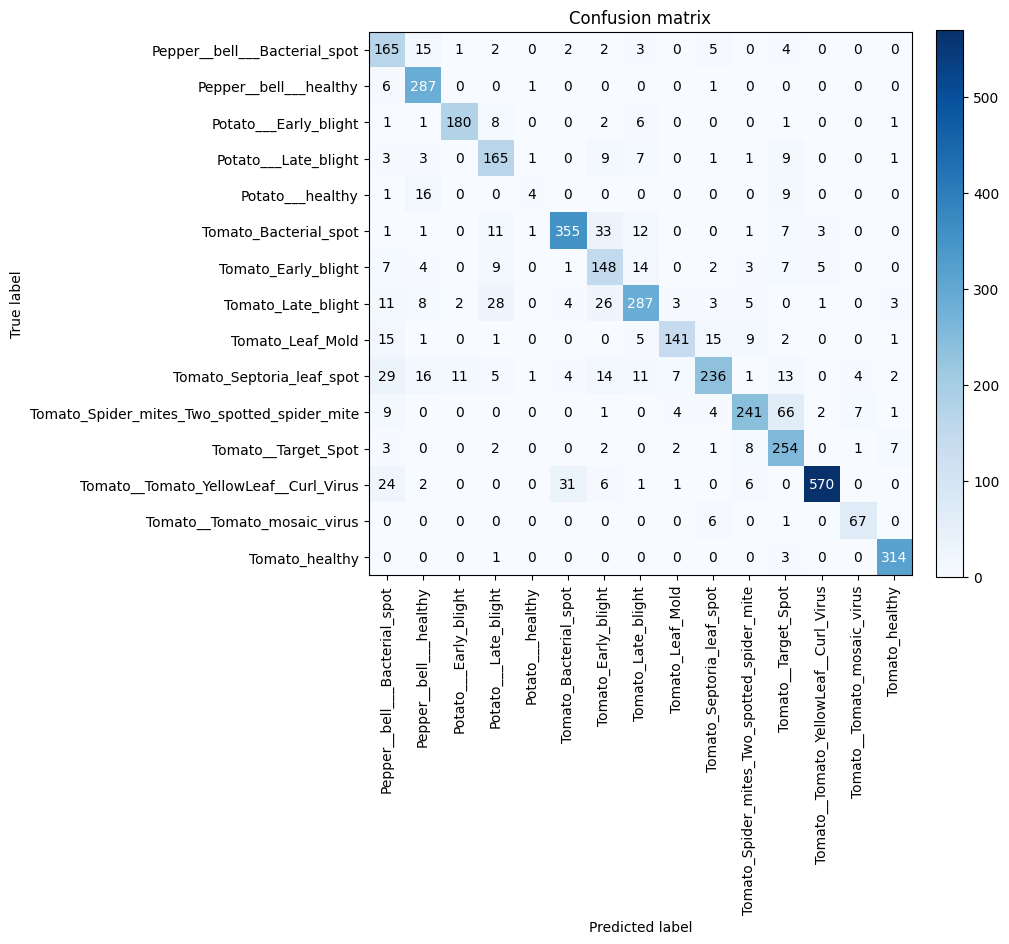

In [ ]:
# evaluate and plot the confusion matrix
evaluate_and_plot(model7, test_generator)

 Increasing the trainig time on the best model did not improve the performance of our model.

### Model 8

### batch size (64)

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# define model architecture
model8 = Sequential()
model8.add(Conv2D(32, (3,3), activation = "relu",padding="same", input_shape = (64,64,3)))
model8.add(MaxPooling2D((2,2),padding="same"))

# another block
model8.add(Conv2D(64, (3,3), activation = "relu",padding="same"))
model8.add(MaxPooling2D((2,2),padding="same"))

# another block

model8.add(Conv2D(128, (3,3), activation = "relu",padding="same"))
model8.add(MaxPooling2D((2,2),padding="same"))


# Add another Conv2D layer with 256 filters and a 3x3 kernel size, using ReLU activation
model8.add(Conv2D(256, (3, 3), activation='relu',padding="same"))
model8.add(MaxPooling2D((2,2),padding="same"))

# Add another Conv2D layer with 256 filters and a 3x3 kernel size, using ReLU activation
model8.add(Conv2D(256, (3, 3), activation='relu',padding="same"))
model8.add(MaxPooling2D((2,2),padding="same"))


# flattem
model8.add(Flatten())

# add dense layers
model8.add(Dense(128, activation = "relu"))
model8.add(Dropout(0.5))

# output layer
# output layer
model8.add(Dense(15,activation = "softmax"))

# compile the model
model8.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# check the summary
model8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

In [ ]:
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant8.hdf5"), save_best_only=True,  verbose=1)

# early stopping
es2  = EarlyStopping(patience=4)


callback_list = [check2,es2]

In [ ]:
# changing batch size to 64 and training our data
history8 = model8.fit(train_generator, steps_per_epoch=train_generator.samples // 64,validation_data=test_generator, validation_steps=test_generator.samples//32, epochs=50 , callbacks=callback_list)

Epoch 1/50
257/258 [============================>.] - ETA: 0s - loss: 2.4282 - accuracy: 0.1916
Epoch 1: val_loss improved from inf to 2.25182, saving model to D:/Ajala ai\plant20.hdf5
258/258 [==============================] - 13s 50ms/step - loss: 2.4268 - accuracy: 0.1923 - val_loss: 2.2518 - val_accuracy: 0.2241
Epoch 2/50
258/258 [==============================] - ETA: 0s - loss: 2.2220 - accuracy: 0.2648
Epoch 2: val_loss improved from 2.25182 to 1.96073, saving model to D:/Ajala ai\plant20.hdf5
258/258 [==============================] - 13s 49ms/step - loss: 2.2220 - accuracy: 0.2648 - val_loss: 1.9607 - val_accuracy: 0.3669
Epoch 3/50
257/258 [============================>.] - ETA: 0s - loss: 1.9007 - accuracy: 0.3809
Epoch 3: val_loss improved from 1.96073 to 1.64261, saving model to D:/Ajala ai\plant20.hdf5
258/258 [==============================] - 13s 49ms/step - loss: 1.8990 - accuracy: 0.3815 - val_loss: 1.6426 - val_accuracy: 0.4749
Epoch 4/50
258/258 [==================

In [ ]:
model8.evaluate(test_generator)

129/129 [==============================] - 2s 13ms/step - loss: 0.7579 - accuracy: 0.7763


[0.7578874826431274, 0.7763221859931946]

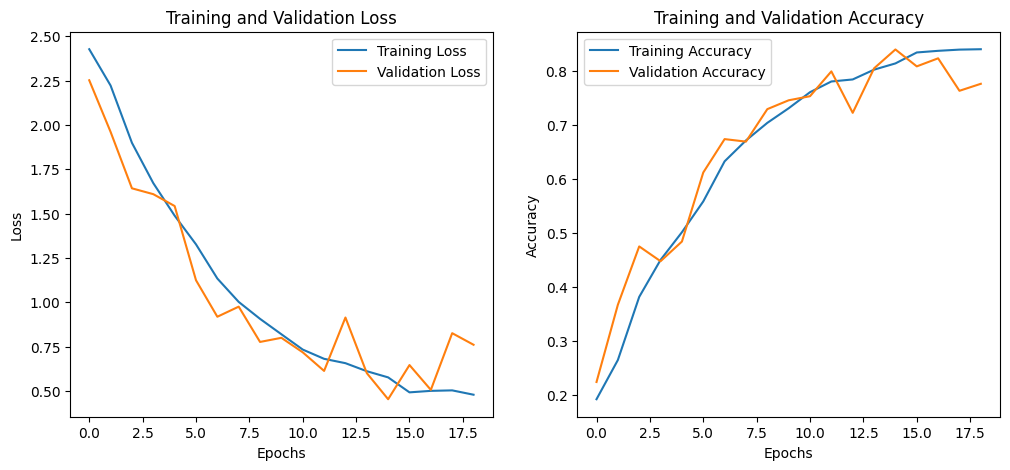

In [ ]:
visualize_model_performance(history8)

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.41      0.93      0.57       199
                     Pepper__bell___healthy       0.84      0.97      0.90       295
                      Potato___Early_blight       0.87      0.85      0.86       200
                       Potato___Late_blight       0.93      0.50      0.65       200
                           Potato___healthy       0.33      0.10      0.15        30
                      Tomato_Bacterial_spot       0.96      0.82      0.88       425
                        Tomato_Early_blight       0.76      0.58      0.66       200
                         Tomato_Late_blight       0.84      0.70      0.76       381
                           Tomato_Leaf_Mold       0.82      0.66      0.73       190
                  Tomato_Septoria_leaf_spot       0.66      0.83      0.74       354
Tomato_Spider_mites_Two_spotted_spider_mi

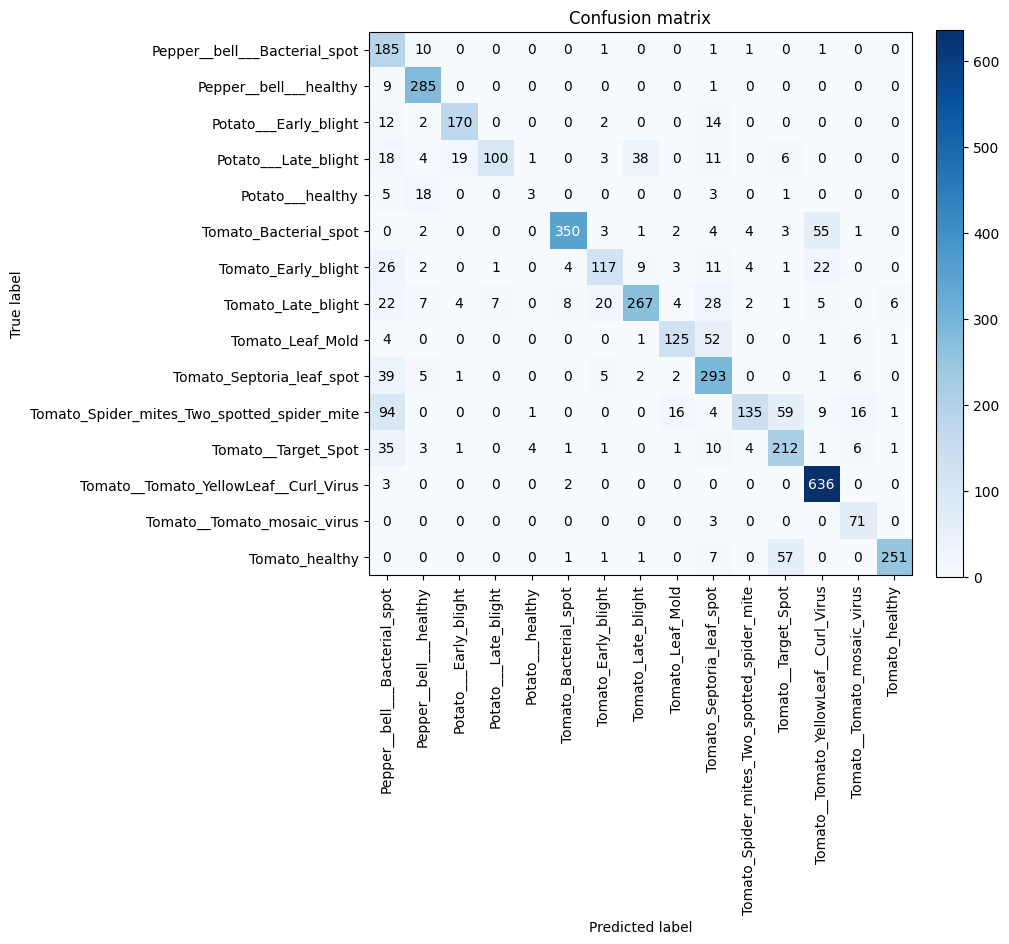

In [ ]:
#  evalute predict and plot
evaluate_and_plot(model8, test_generator)

##### the model performance  was not improve with increasing the batch size

#### In summary, the Adam optimizer emerged as the most effective choice for the custom model. Other hyperparameter tuning techniques (batch size and learning rate) did not improve model performance. Thus, the optimal custom model configuration comprises four convolutional layers, the Adam optimizer (0.001).

# Pretrain model

## VGG16

#### Model 9

In [ ]:
# learning rate of adam
# Clearing backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### Apply the preprocessing used for vgg16

In [ ]:
from keras.applications.vgg16 import VGG16,preprocess_input

train_datagen2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

test_datagen2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)


In [ ]:

train_generator2 = train_datagen2.flow_from_directory(train_dir, target_size = (64,64), batch_size = 32)
test_generator2 = test_datagen2.flow_from_directory(test_dir, target_size = (64,64), batch_size = 32)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [ ]:
# define vgg16

# include_top=False (mean dont include the fully connect layer)
#
base_model =VGG16(include_top=False, input_shape=(64,64,3), weights = "imagenet")

# freeze layer
for layer in base_model.layers: # as you go through the base_model
    layer.trainable = False # freeze the layersi.e dont change the weight (dont update the weight)
    # i.e we want the convolution layers

# define the architecure
model9 = Sequential()
model9.add(base_model) #the convolution layers in our model

# flatten

model9.add(Flatten())

# add the dense layer
model9.add(Dense(128,activation ="relu"))
model9.add(Dropout(0.5))

# output layer
model9.add(Dense(15, activation ="softmax"))

model9.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model9.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 14,978,895
Trainable params: 264,207
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant9.hdf5"), save_best_only=True,  verbose=1)

# early stopping
es2  = EarlyStopping(patience=4)


callback_list = [check2,es2]

In [ ]:
# training our model
history9 = model9.fit(train_generator2, validation_data=test_generator2, epochs=50, callbacks=callback_list, batch_size =32)

Epoch 1/50
517/517 [==============================] - ETA: 0s - loss: 2.3053 - accuracy: 0.4046
Epoch 1: val_loss improved from inf to 1.10288, saving model to D:/Ajala ai\plant23.hdf5
517/517 [==============================] - 7s 12ms/step - loss: 2.3053 - accuracy: 0.4046 - val_loss: 1.1029 - val_accuracy: 0.6613
Epoch 2/50
517/517 [==============================] - ETA: 0s - loss: 1.3631 - accuracy: 0.5685
Epoch 2: val_loss improved from 1.10288 to 0.91624, saving model to D:/Ajala ai\plant23.hdf5
517/517 [==============================] - 6s 11ms/step - loss: 1.3631 - accuracy: 0.5685 - val_loss: 0.9162 - val_accuracy: 0.7222
Epoch 3/50
517/517 [==============================] - ETA: 0s - loss: 1.1438 - accuracy: 0.6273
Epoch 3: val_loss improved from 0.91624 to 0.75591, saving model to D:/Ajala ai\plant23.hdf5
517/517 [==============================] - 6s 11ms/step - loss: 1.1438 - accuracy: 0.6273 - val_loss: 0.7559 - val_accuracy: 0.7686
Epoch 4/50
516/517 [=====================

In [ ]:
model9.evaluate(test_generator2)

129/129 [==============================] - 1s 9ms/step - loss: 0.5594 - accuracy: 0.8421


[0.5594167113304138, 0.8420669436454773]

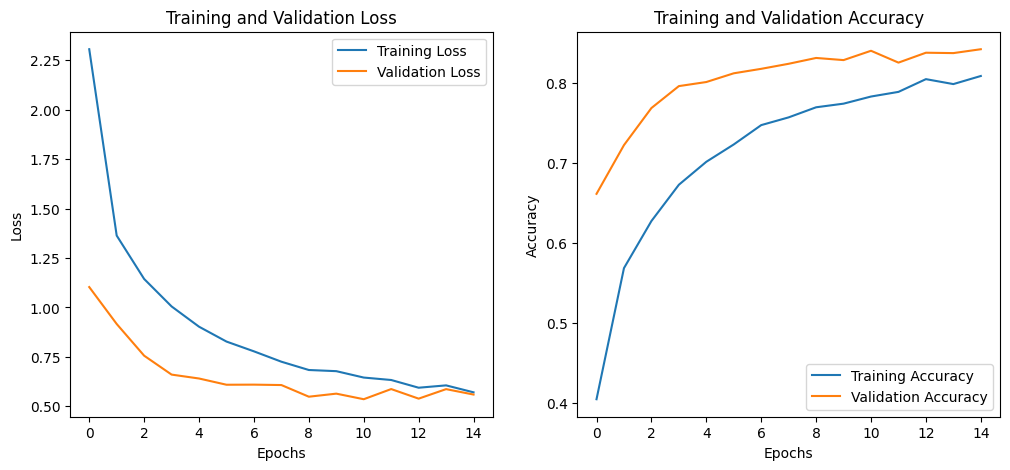

In [ ]:
visualize_model_performance(history9)

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.86      0.84      0.85       199
                     Pepper__bell___healthy       0.93      0.94      0.93       295
                      Potato___Early_blight       0.95      0.91      0.93       200
                       Potato___Late_blight       0.81      0.83      0.82       200
                           Potato___healthy       0.92      0.77      0.84        30
                      Tomato_Bacterial_spot       0.84      0.88      0.86       425
                        Tomato_Early_blight       0.58      0.55      0.56       200
                         Tomato_Late_blight       0.80      0.79      0.79       381
                           Tomato_Leaf_Mold       0.85      0.81      0.83       190
                  Tomato_Septoria_leaf_spot       0.81      0.79      0.80       354
Tomato_Spider_mites_Two_spotted_spider_mi

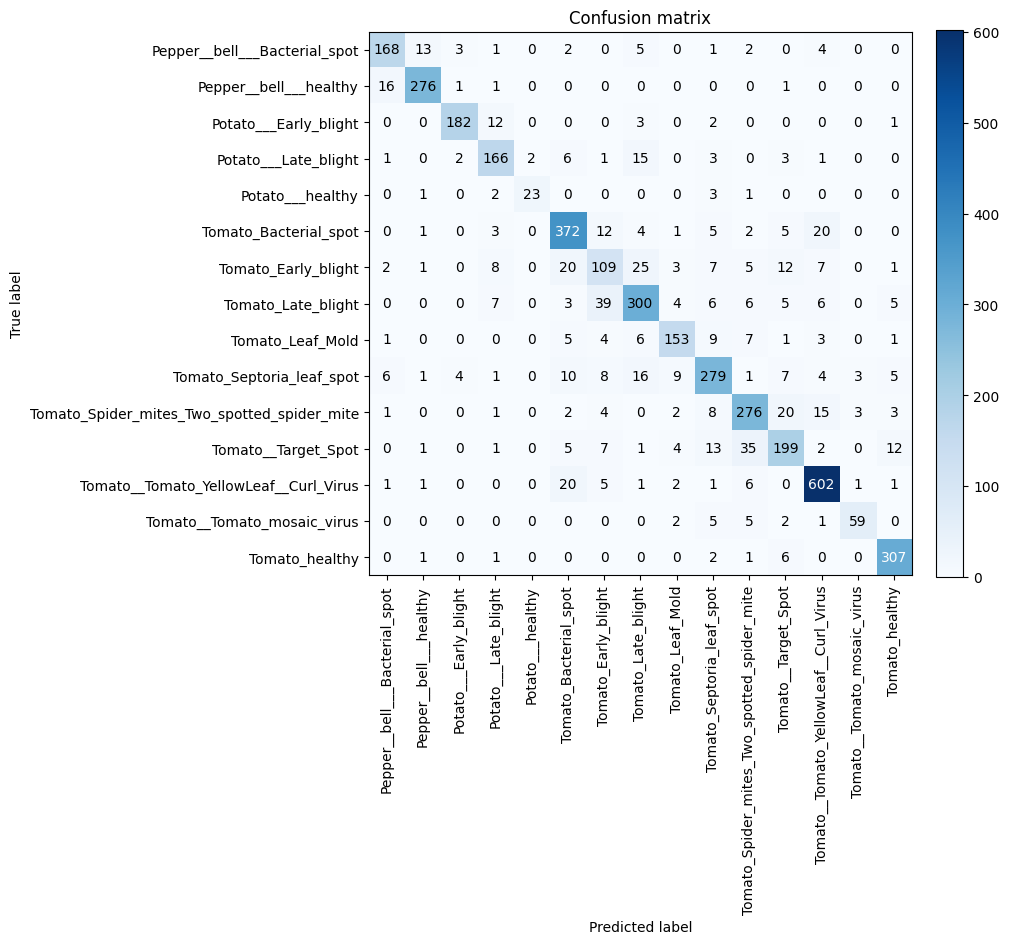

In [ ]:
 # get the classification report and confusion matric
evaluate_and_plot(model9, test_generator2)

###  VGG19

#### Model 10

In [ ]:
# learning rate of adam
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Implement transfer learning

train_datagen3 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

test_datagen3 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)


train_generator3 = train_datagen3.flow_from_directory(train_dir, target_size=(64, 64), batch_size=32)
test_generator3 = test_datagen3.flow_from_directory(test_dir, target_size=(64, 64), batch_size=32)

# define vgg19 (use VGG19 instead of VGG16)
from keras.applications.vgg19 import VGG19

base_model2 = VGG19(include_top=False, input_shape=(64, 64, 3), weights="imagenet")

# freeze layers
for layer in base_model2.layers:
    layer.trainable = False

# define the architecture
model10 = Sequential()
model10.add(base_model2)
model10.add(Flatten())
model10.add(Dense(128, activation="relu"))
model10.add(Dropout(0.5))
model10.add(Dense(15, activation="softmax"))

model10.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model10.summary()

check2 = ModelCheckpoint(os.path.join(model_filepath, "plant10.hdf5"), save_best_only=True, verbose=1)
es2 = EarlyStopping(patience=4)

callback_list = [check2, es2]


# Training
history10 = model10.fit(train_generator3, validation_data=test_generator3, epochs=50, callbacks=callback_list,batch_size =32)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 20,288,591
Trainable params: 264,207
Non-trainable params: 20,024,384
_________________

In [ ]:
 # model evaluation
model10.evaluate(test_generator3)

129/129 [==============================] - 1s 9ms/step - loss: 0.5333 - accuracy: 0.8362


[0.533332884311676, 0.836244523525238]

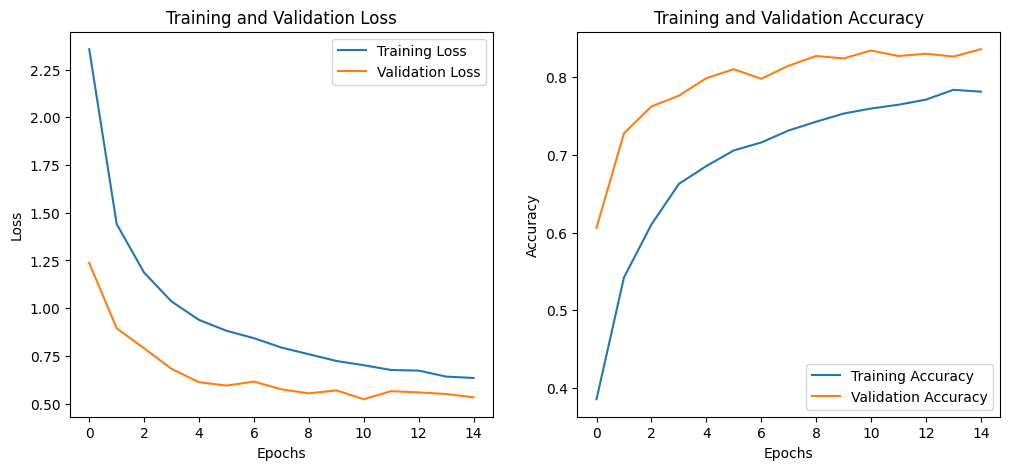

In [ ]:
visualize_model_performance(history10)

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.84      0.85      0.85       199
                     Pepper__bell___healthy       0.96      0.89      0.92       295
                      Potato___Early_blight       0.96      0.87      0.91       200
                       Potato___Late_blight       0.79      0.90      0.84       200
                           Potato___healthy       0.86      0.60      0.71        30
                      Tomato_Bacterial_spot       0.86      0.90      0.88       425
                        Tomato_Early_blight       0.59      0.58      0.59       200
                         Tomato_Late_blight       0.84      0.76      0.80       381
                           Tomato_Leaf_Mold       0.87      0.67      0.76       190
                  Tomato_Septoria_leaf_spot       0.73      0.82      0.77       354
Tomato_Spider_mites_Two_spotted_spider_mi

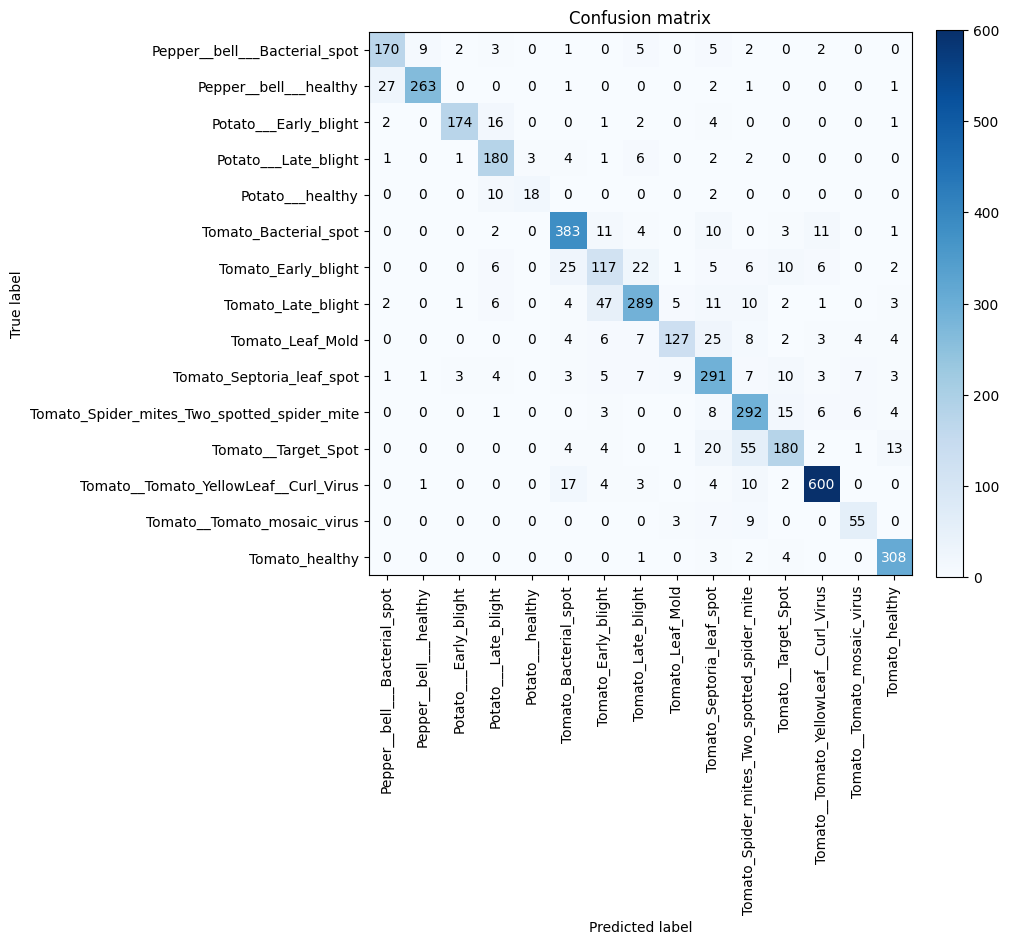

In [ ]:
# get classication report and confusiom matrix
evaluate_and_plot(model10, test_generator3)

### DenseNet121

#### Model11

In [ ]:

# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Implement transfer learning
train_datagen4 = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)
test_datagen4 = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

# Define data generators for training and testing
train_generator4 = train_datagen4.flow_from_directory(train_dir, target_size=(64, 64), batch_size=32)
test_generator4 = test_datagen4.flow_from_directory(test_dir, target_size=(64, 64), batch_size=32)

# Define DenseNet121
from keras.applications.densenet import DenseNet121

# Load the pre-trained DenseNet121 model without the top (fully connected) layers
base_model3 = DenseNet121(include_top=False, input_shape=(64, 64, 3), weights="imagenet")

# Freeze layers (prevent them from being updated during training)
for layer in base_model3.layers:
    layer.trainable = False

# Define the architecture of the new model
model11 = Sequential()
model11.add(base_model3)  # Add the convolutional layers from DenseNet121
model11.add(GlobalAveragePooling2D())  # Apply Global Average Pooling to reduce dimensions
model11.add(Dense(128, activation="relu"))  # Add a dense layer with ReLU activation
model11.add(Dropout(0.5))  # Add dropout for regularization
model11.add(Dense(15, activation="softmax"))  # Output layer for classification

# Compile the model with the Adam optimizer and categorical cross-entropy loss
model11.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Display a summary of the model architecture
model11.summary()

# Define callbacks for model checkpointing and early stopping
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant11.hdf5"), save_best_only=True, verbose=1)
es2 = EarlyStopping(patience=4)

# Create a list of callbacks to be used during training
callback_list = [check2, es2]

# Train the model using the data generators and specified callbacks
history11 = model11.fit(train_generator4, validation_data=test_generator4, epochs=50, callbacks=callback_list,batch_size =32)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 7,170,639
Trainable p

In [ ]:
 # evalute
model11.evaluate(test_generator4)

129/129 [==============================] - 2s 17ms/step - loss: 0.4115 - accuracy: 0.8661


[0.4114511013031006, 0.8660843968391418]

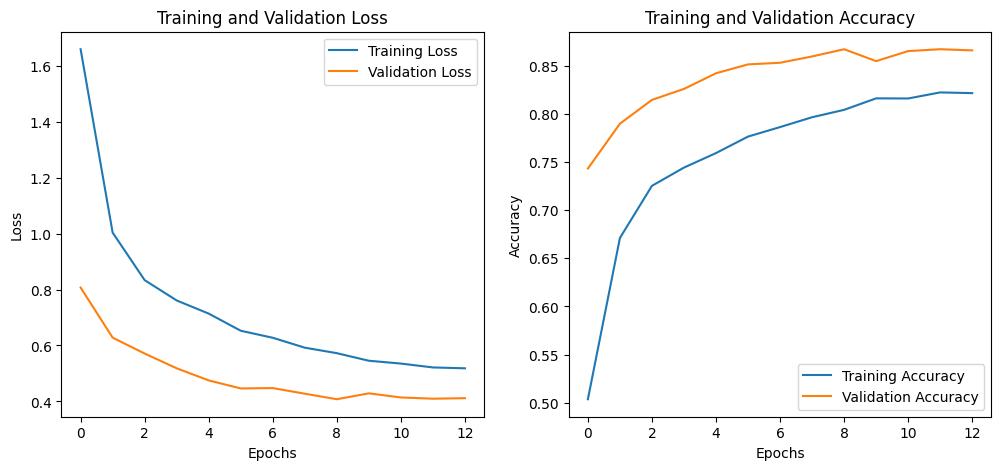

In [ ]:
visualize_model_performance(history11)

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.96      0.79      0.87       199
                     Pepper__bell___healthy       0.88      0.98      0.93       295
                      Potato___Early_blight       0.94      0.94      0.94       200
                       Potato___Late_blight       0.82      0.90      0.86       200
                           Potato___healthy       0.83      0.67      0.74        30
                      Tomato_Bacterial_spot       0.89      0.93      0.91       425
                        Tomato_Early_blight       0.74      0.66      0.70       200
                         Tomato_Late_blight       0.86      0.86      0.86       381
                           Tomato_Leaf_Mold       0.74      0.88      0.81       190
                  Tomato_Septoria_leaf_spot       0.77      0.80      0.78       354
Tomato_Spider_mites_Two_spotted_spider_mi

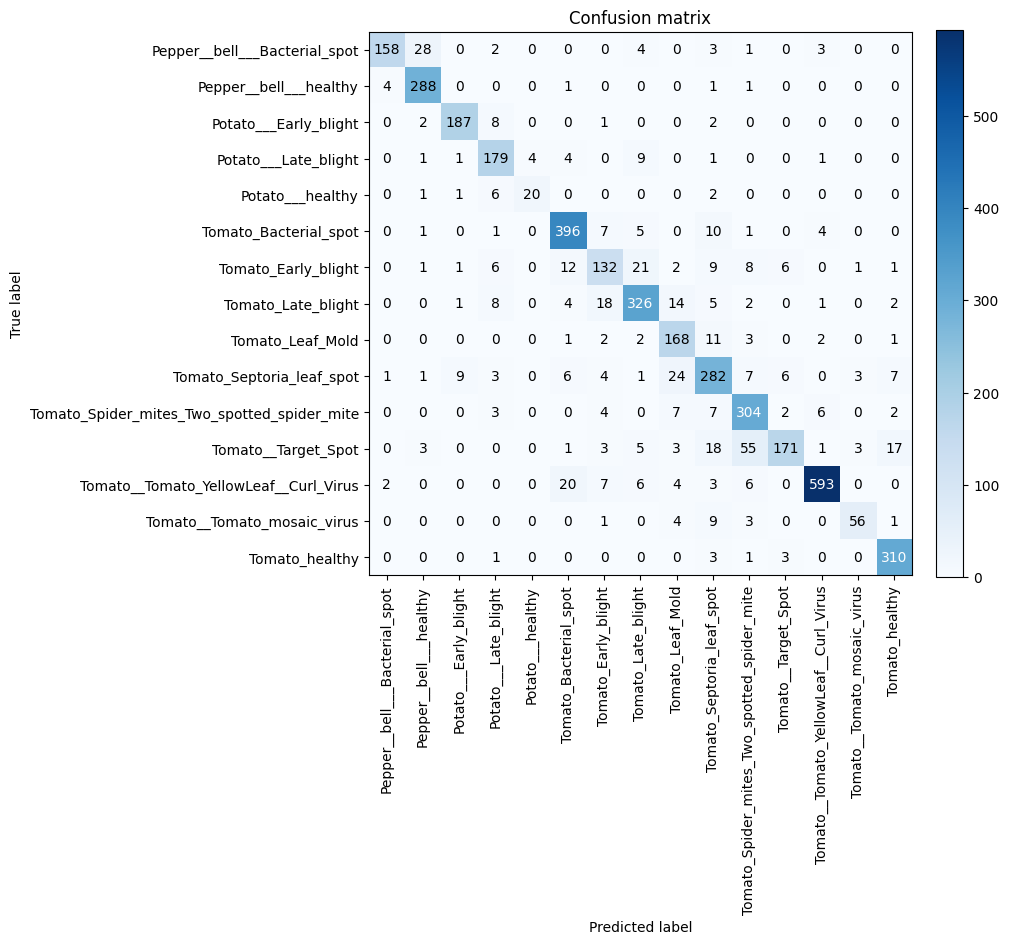

In [ ]:
# get classifaction report and confusion matrix
evaluate_and_plot(model11, test_generator4)#

### Inception V3

#### Model 12

In [ ]:
# Learning rate of Adam
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Implement transfer learning
train_datagen6 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
test_datagen6 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

# Define data generators for training and testing
train_generator6 = train_datagen6.flow_from_directory(train_dir, target_size=(64, 64), batch_size=32)
test_generator6 = test_datagen6.flow_from_directory(test_dir, target_size=(64, 64), batch_size=32)

# Define InceptionV3
from keras.applications.inception_v3 import InceptionV3

# Load the pre-trained InceptionV3 model without the top (fully connected) layers
base_model6 = InceptionV3(include_top=False, input_shape=(64, 64, 3), weights="imagenet")

# Freeze layers (prevent the weight from being updated during training)
for layer in base_model6.layers:
    layer.trainable = False

# Define the architecture of the new model
model12 = Sequential()
model12.add(base_model6)  # Add the convolutional layers from InceptionV4
model12.add(GlobalAveragePooling2D())  # Apply Global Average Pooling to reduce dimensions
model12.add(Dense(128, activation="relu"))  # Add a dense layer with ReLU activation
model12.add(Dropout(0.5))  # Add dropout for regularization
model12.add(Dense(15, activation="softmax"))  # Output layer for classification

# Compile the model with the Adam optimizer and categorical cross-entropy loss
model12.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Display a summary of the model architecture
model12.summary()

# Define callbacks for model checkpointing and early stopping
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant27.hdf5"), save_best_only=True, verbose=1)
es2 = EarlyStopping(patience=4)

# Create a list of callbacks to be used during training
callback_list = [check2, es2]

# Train the model using the data generators and specified callbacks for 50 epochs
history12 = model12.fit(train_generator6, validation_data=test_generator6, epochs=50, callbacks=callback_list, batch_size=32)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 22,066,991
Trainable 

Epoch 24/50
516/517 [============================>.] - ETA: 0s - loss: 0.5269 - accuracy: 0.8131
Epoch 24: val_loss improved from 0.37926 to 0.37533, saving model to D:/Ajala ai\plant27.hdf5
517/517 [==============================] - 25s 48ms/step - loss: 0.5274 - accuracy: 0.8130 - val_loss: 0.3753 - val_accuracy: 0.8705
Epoch 25/50
517/517 [==============================] - ETA: 0s - loss: 0.5299 - accuracy: 0.8043
Epoch 25: val_loss improved from 0.37533 to 0.37182, saving model to D:/Ajala ai\plant27.hdf5
517/517 [==============================] - 25s 48ms/step - loss: 0.5299 - accuracy: 0.8043 - val_loss: 0.3718 - val_accuracy: 0.8729
Epoch 26/50
516/517 [============================>.] - ETA: 0s - loss: 0.5143 - accuracy: 0.8101
Epoch 26: val_loss did not improve from 0.37182
517/517 [==============================] - 24s 46ms/step - loss: 0.5138 - accuracy: 0.8102 - val_loss: 0.3982 - val_accuracy: 0.8605
Epoch 27/50
517/517 [==============================] - ETA: 0s - loss: 0.5

In [ ]:
model12.evaluate(test_generator6)

129/129 [==============================] - 5s 40ms/step - loss: 0.3922 - accuracy: 0.8656


[0.39223477244377136, 0.8655992150306702]

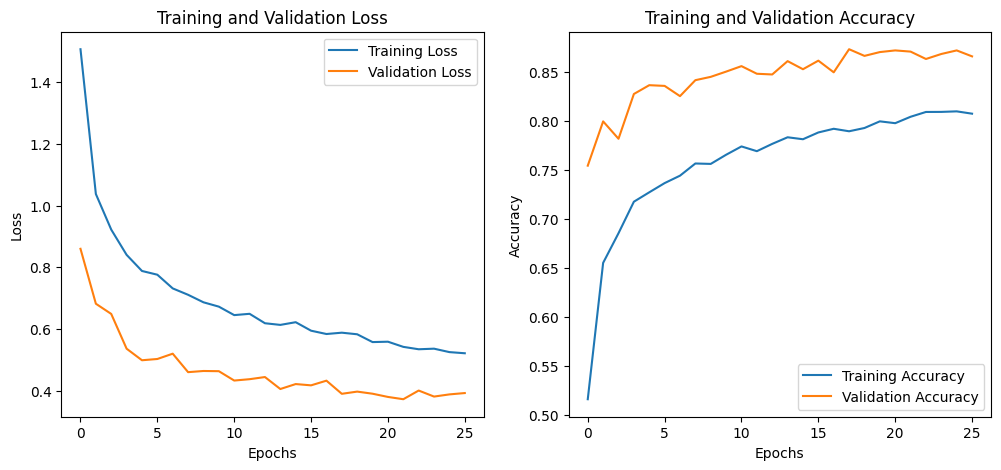

In [ ]:
visualize_model_performance(history12)

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.95      0.76      0.85       199
                     Pepper__bell___healthy       0.87      0.98      0.92       295
                      Potato___Early_blight       0.92      0.97      0.95       200
                       Potato___Late_blight       0.88      0.83      0.86       200
                           Potato___healthy       0.91      0.70      0.79        30
                      Tomato_Bacterial_spot       0.81      0.97      0.88       425
                        Tomato_Early_blight       0.84      0.43      0.57       200
                         Tomato_Late_blight       0.86      0.83      0.85       381
                           Tomato_Leaf_Mold       0.87      0.78      0.83       190
                  Tomato_Septoria_leaf_spot       0.80      0.87      0.83       354
Tomato_Spider_mites_Two_spotted_spider_mi

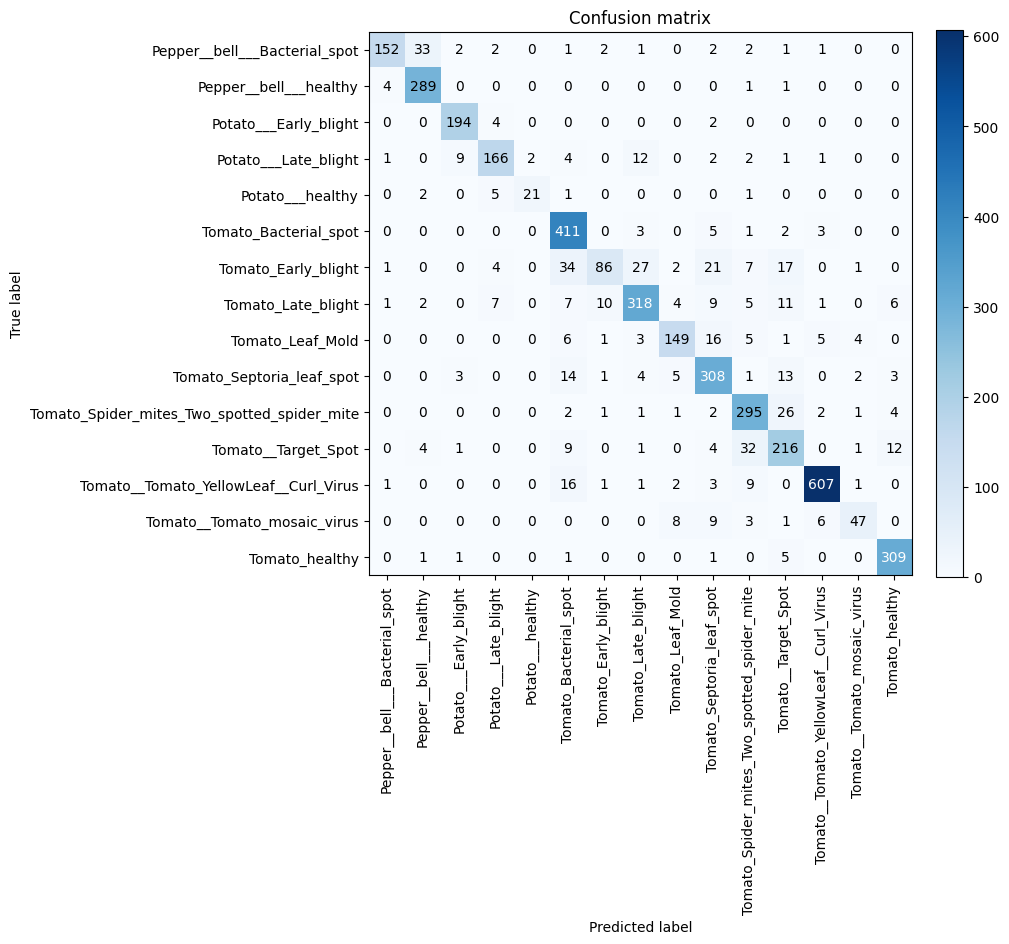

In [ ]:
# get confusion matrix and classification report
evaluate_and_plot(model12, test_generator6)#

### EfficientNetB0


#### Model 13

In [ ]:

# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Implement transfer learning
train_datagen8 = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
test_datagen8 = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

# Define data generators for training and testing
train_generator8 = train_datagen8.flow_from_directory(train_dir, target_size=(64, 64), batch_size=32)
test_generator8 = test_datagen8.flow_from_directory(test_dir, target_size=(64, 64), batch_size=32)

# Define EfficientNet
from tensorflow.keras.applications import EfficientNetB0  # You can choose the appropriate variant (e.g., B0, B1, etc.)

# Load the pre-trained EfficientNet model without the top (fully connected) layers
base_model8 = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

# Freeze layers (prevent them from being updated during training)
for layer in base_model8.layers:
    layer.trainable = False

# Define the architecture of the new model
model13 = Sequential()
model13.add(base_model8)  # Add the convolutional layers from EfficientNet
model13.add(GlobalAveragePooling2D())  # Apply Global Average Pooling to reduce dimensions
model13.add(Dense(128, activation="relu"))  # Add a dense layer with ReLU activation
model13.add(Dropout(0.5))  # Add dropout for regularization
model13.add(Dense(15, activation="softmax"))  # Output layer for classification

# Compile the model with the Adam optimizer and categorical cross-entropy loss
model13.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Display a summary of the model architecture
model13.summary()

# Define callbacks for model checkpointing and early stopping
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant29.hdf5"), save_best_only=True, verbose=1)
es2 = EarlyStopping(patience=4)

# Create a list of callbacks to be used during training
callback_list = [check2, es2]

# Train the model using the data generators and specified callbacks for 50 epochs
history13 = model13.fit(train_generator8, validation_data=test_generator8, epochs=50, callbacks=callback_list, batch_size=32)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
16705208/16705208 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                    

517/517 [==============================] - 9s 18ms/step - loss: 0.6902 - accuracy: 0.7635 - val_loss: 0.4391 - val_accuracy: 0.8479
Epoch 23/50
515/517 [============================>.] - ETA: 0s - loss: 0.6802 - accuracy: 0.7714
Epoch 23: val_loss did not improve from 0.43911
517/517 [==============================] - 8s 16ms/step - loss: 0.6804 - accuracy: 0.7709 - val_loss: 0.4543 - val_accuracy: 0.8399
Epoch 24/50
516/517 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.7646
Epoch 24: val_loss did not improve from 0.43911
517/517 [==============================] - 9s 17ms/step - loss: 0.6848 - accuracy: 0.7644 - val_loss: 0.4402 - val_accuracy: 0.8513
Epoch 25/50
514/517 [============================>.] - ETA: 0s - loss: 0.6773 - accuracy: 0.7694
Epoch 25: val_loss did not improve from 0.43911
517/517 [==============================] - 8s 16ms/step - loss: 0.6785 - accuracy: 0.7690 - val_loss: 0.4420 - val_accuracy: 0.8428
Epoch 26/50
516/517 [================

In [ ]:
model13.evaluate(test_generator8)

129/129 [==============================] - 2s 13ms/step - loss: 0.4458 - accuracy: 0.8489


[0.4458461403846741, 0.8488597869873047]

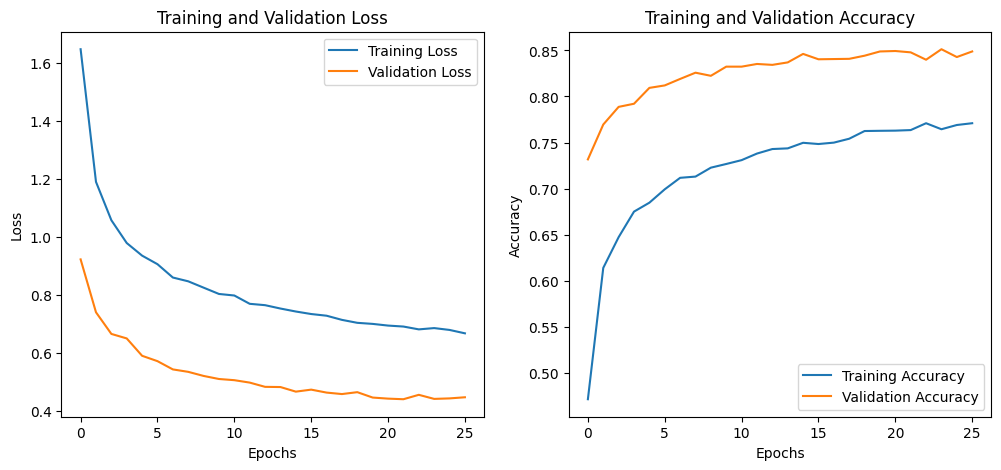

In [ ]:
visualize_model_performance(history13)

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.96      0.70      0.81       199
                     Pepper__bell___healthy       0.89      0.96      0.92       295
                      Potato___Early_blight       0.91      0.96      0.93       200
                       Potato___Late_blight       0.90      0.88      0.89       200
                           Potato___healthy       0.77      0.77      0.77        30
                      Tomato_Bacterial_spot       0.87      0.93      0.90       425
                        Tomato_Early_blight       0.80      0.52      0.63       200
                         Tomato_Late_blight       0.85      0.84      0.84       381
                           Tomato_Leaf_Mold       0.82      0.78      0.80       190
                  Tomato_Septoria_leaf_spot       0.76      0.79      0.78       354
Tomato_Spider_mites_Two_spotted_spider_mi

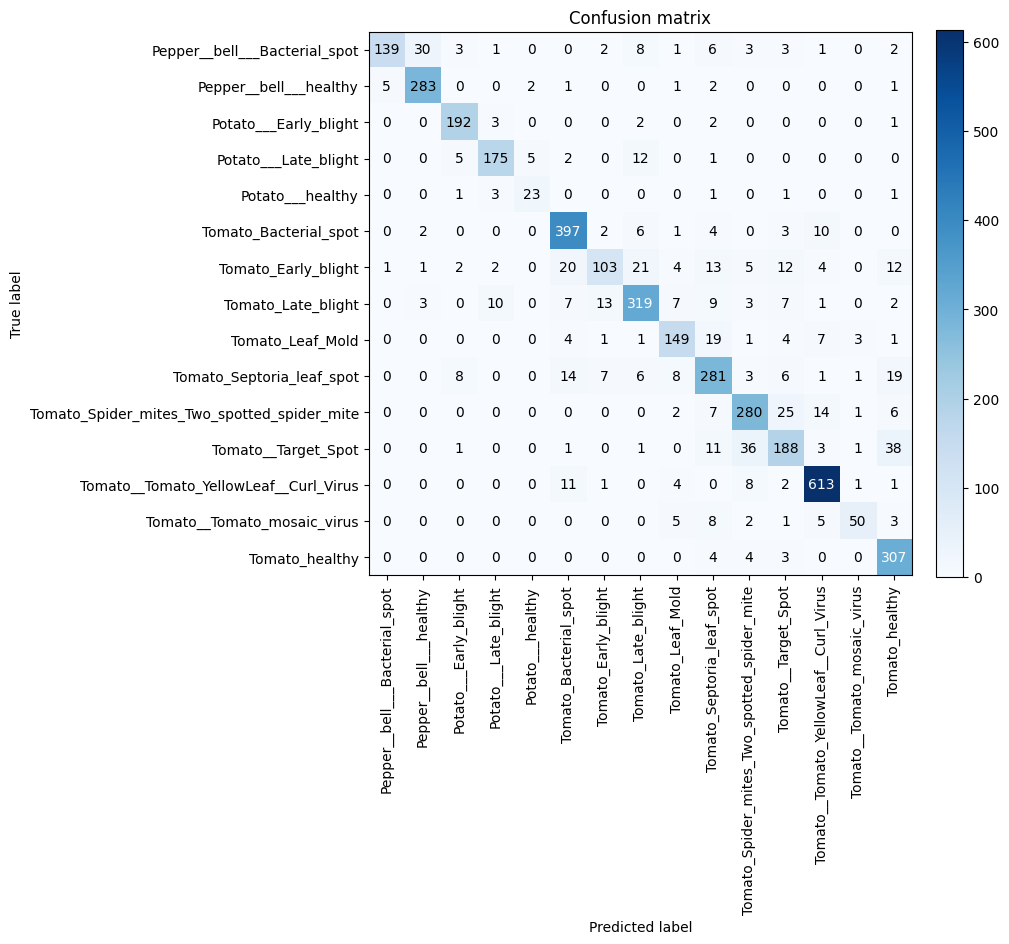

In [ ]:
# get classification report and confusion matrix
evaluate_and_plot(model13, test_generator8)#

### MobileNet

#### Model 14

In [ ]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Implement transfer learning
train_datagen7 = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)
test_datagen7 = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

# Define data generators for training and testing
train_generator7 = train_datagen7.flow_from_directory(train_dir, target_size=(64, 64), batch_size=32)
test_generator7 = test_datagen7.flow_from_directory(test_dir, target_size=(64, 64), batch_size=32)

# Define MobileNet with weights pre-trained on ImageNet
from tensorflow.keras.applications import MobileNet

# Load the pre-trained MobileNet model without the top (fully connected) layers
base_model7 = MobileNet(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

# Freeze layers (prevent them from being updated during training)
for layer in base_model7.layers:
    layer.trainable = False

# Define the architecture of the new model
model14 = Sequential()
model14.add(base_model7)  # Add the convolutional layers from MobileNet
model14.add(GlobalAveragePooling2D())  # Apply Global Average Pooling to reduce dimensions
model14.add(Dense(128, activation="relu"))  # Add a dense layer with ReLU activation
model14.add(Dropout(0.5))  # Add dropout for regularization
model14.add(Dense(15, activation="softmax"))  # Output layer for classification

# Compile the model with the Adam optimizer and categorical cross-entropy loss
model14.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Display a summary of the model architecture
model14.summary()

# Define callbacks for model checkpointing and early stopping
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant28.hdf5"), save_best_only=True, verbose=1)
es2 = EarlyStopping(patience=4)

# Create a list of callbacks to be used during training
callback_list = [check2, es2]

# Train the model using the data generators and specified callbacks for 50 epochs
history14 = model14.fit(train_generator7, validation_data=test_generator7, epochs=50, callbacks=callback_list, batch_size=32)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 2, 2, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                   

In [ ]:
model14.evaluate(test_generator7)

129/129 [==============================] - 1s 11ms/step - loss: 0.5481 - accuracy: 0.8246


[0.548080325126648, 0.8245996832847595]

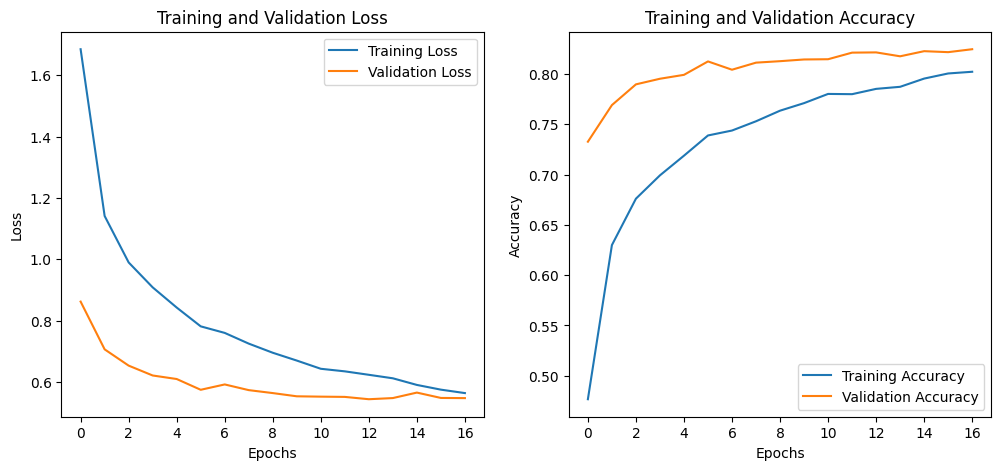

In [ ]:
visualize_model_performance(history14)

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.92      0.84      0.88       199
                     Pepper__bell___healthy       0.90      0.96      0.93       295
                      Potato___Early_blight       0.91      0.91      0.91       200
                       Potato___Late_blight       0.79      0.85      0.82       200
                           Potato___healthy       0.93      0.43      0.59        30
                      Tomato_Bacterial_spot       0.81      0.85      0.83       425
                        Tomato_Early_blight       0.61      0.53      0.57       200
                         Tomato_Late_blight       0.76      0.78      0.77       381
                           Tomato_Leaf_Mold       0.78      0.75      0.77       190
                  Tomato_Septoria_leaf_spot       0.73      0.76      0.75       354
Tomato_Spider_mites_Two_spotted_spider_mi

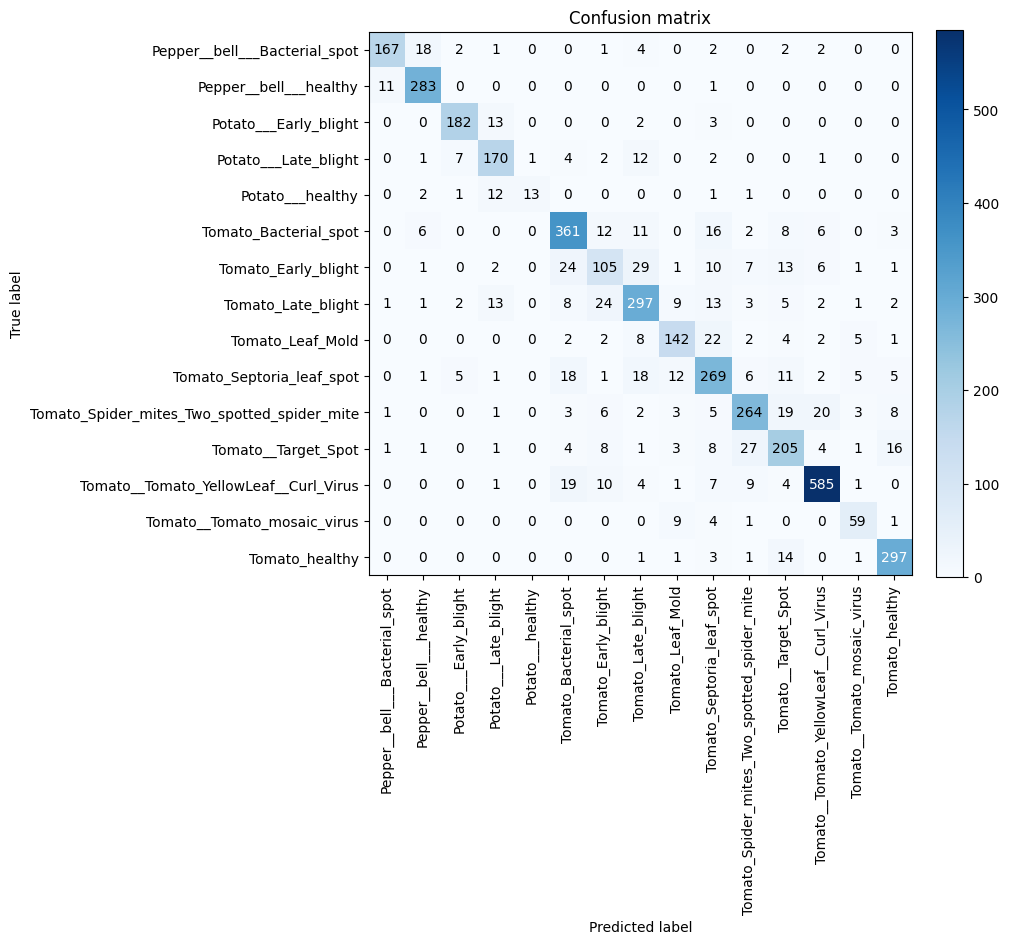

In [ ]:
# Example usage with the same test generator for all models
evaluate_and_plot(model14, test_generator7)#

mobile net accuracy is low because the size of data set is 64 by 64 and mobile net is trained with a size of 224

###  ResNet-50

#### Model 15

In [ ]:

# Clearing backend
backend.clear_session()

# Fixing the seed for random number generator
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Implement transfer learning
train_datagen5 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_datagen5 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

# Define data generators for training and testing
train_generator5 = train_datagen5.flow_from_directory(train_dir, target_size=(64, 64), batch_size=32)
test_generator5 = test_datagen5.flow_from_directory(test_dir, target_size=(64, 64), batch_size=32)

# Define ResNet-50 (use ResNet-50 instead of VGG19)
from keras.applications.resnet import ResNet50

# Load the pre-trained ResNet-50 model without the top (fully connected) layers
base_model5 = ResNet50(include_top=False, input_shape=(64, 64, 3), weights="imagenet")

# Freeze layers (prevent them from being updated during training)
for layer in base_model5.layers:
    layer.trainable = False

# Define the architecture of the new model
model15 = Sequential()
model15.add(base_model5)  # Add the convolutional layers from ResNet-50
model15.add(GlobalAveragePooling2D())  # Apply Global Average Pooling to reduce dimensions
model15.add(Dense(128, activation="relu"))  # Add a dense layer with ReLU activation
model15.add(Dropout(0.5))  # Add dropout for regularization
model15.add(Dense(15, activation="softmax"))  # Output layer for classification

# Compile the model with the Adam optimizer and categorical cross-entropy loss
model15.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Display a summary of the model architecture
model15.summary()

# Define callbacks for model checkpointing and early stopping
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant26.hdf5"), save_best_only=True, verbose=1)
es2 = EarlyStopping(patience=4)

# Create a list of callbacks to be used during training
callback_list = [check2, es2]

# Train the model using the data generators and specified callbacks for 50 epochs
history15 = model15.fit(train_generator5, validation_data=test_generator5, epochs=50, callbacks=callback_list,batch_size =32)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 23,851,919
Trainable 

In [ ]:
model15.evaluate(test_generator5)

129/129 [==============================] - 2s 12ms/step - loss: 0.3401 - accuracy: 0.9027


[0.3401084244251251, 0.902717113494873]

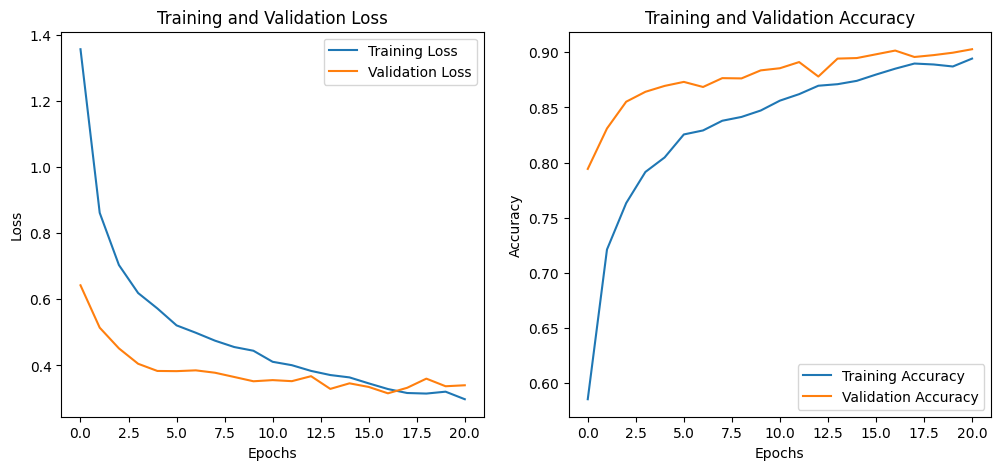

In [ ]:
visualize_model_performance(history15)

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.91      0.95      0.93       199
                     Pepper__bell___healthy       0.95      0.98      0.96       295
                      Potato___Early_blight       0.92      0.96      0.94       200
                       Potato___Late_blight       0.89      0.93      0.91       200
                           Potato___healthy       0.92      0.80      0.86        30
                      Tomato_Bacterial_spot       0.93      0.94      0.93       425
                        Tomato_Early_blight       0.77      0.65      0.71       200
                         Tomato_Late_blight       0.87      0.88      0.87       381
                           Tomato_Leaf_Mold       0.88      0.86      0.87       190
                  Tomato_Septoria_leaf_spot       0.84      0.92      0.88       354
Tomato_Spider_mites_Two_spotted_spider_mi

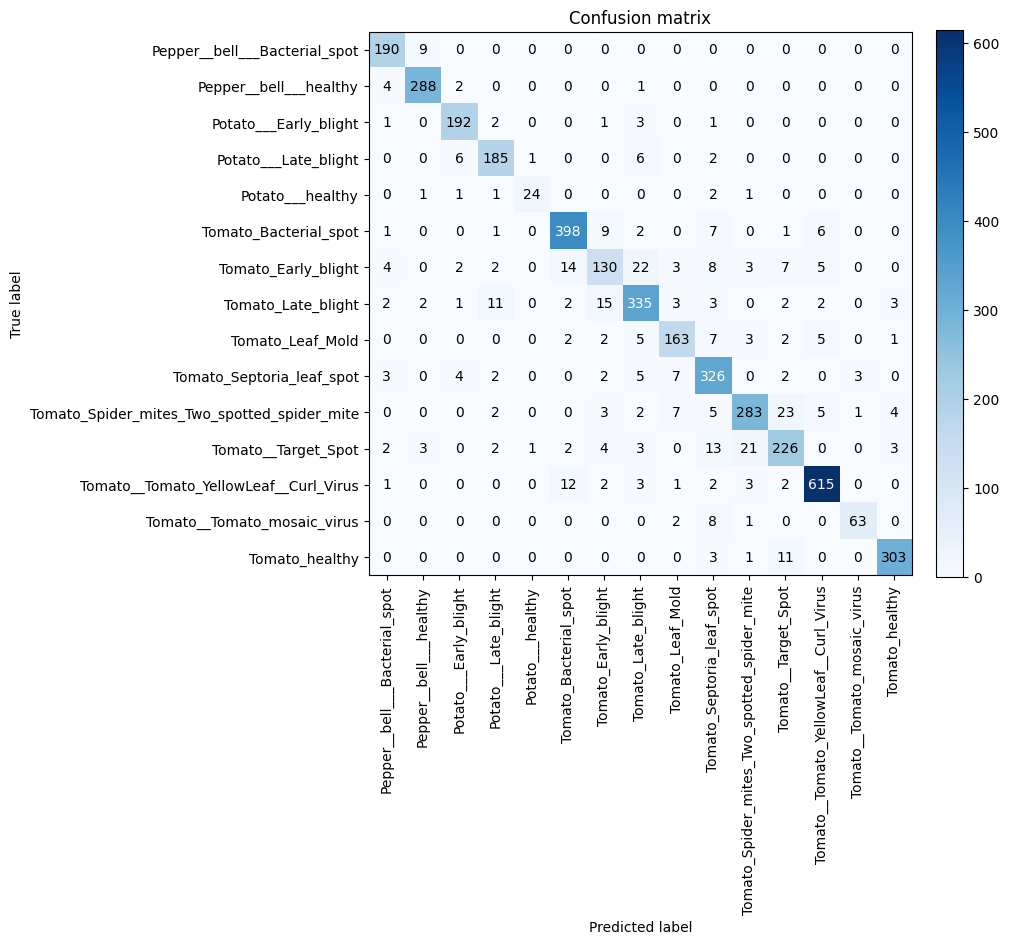

In [ ]:
# plot the confusion matric and classification report
evaluate_and_plot(model15, test_generator5)#

#### visualizing the accuracy of the pretrain model during the training process

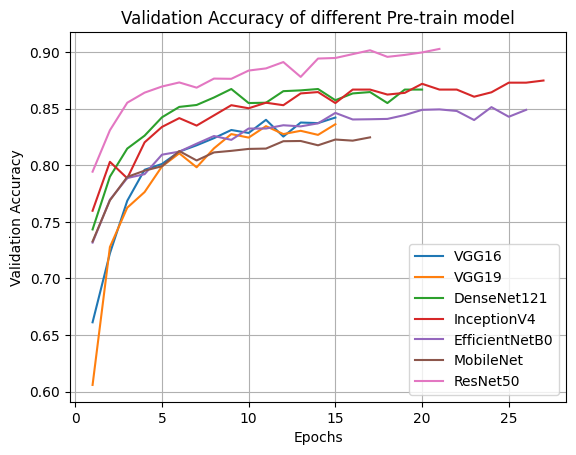

In [ ]:
# Define the training logs for each model
models_logs = {
    "VGG16": [
        0.6613, 0.7222, 0.7686, 0.7960, 0.8011,
        0.8120, 0.8176, 0.8239, 0.8311, 0.8285,
        0.8401, 0.8253, 0.8377, 0.8372, 0.8421
    ],
    "VGG19": [
        0.6060, 0.7278, 0.7625, 0.7763, 0.7989,
        0.8105, 0.7982, 0.8149, 0.8275, 0.8244,
        0.8345, 0.8275, 0.8304, 0.8268, 0.8362
    ],
    "DenseNet121": [
        0.7433, 0.7899, 0.8147, 0.8261, 0.8423,
        0.8515, 0.8532, 0.8598, 0.8673, 0.8549,
        0.8552, 0.8654, 0.8661, 0.8673, 0.8574,
        0.8634, 0.8646, 0.8549, 0.8668, 0.8668
    ],
    "InceptionV4": [
        0.7598, 0.8030, 0.7885, 0.8202, 0.8338,
        0.8416, 0.8350, 0.8440, 0.8530, 0.8503,
        0.8552, 0.8530, 0.8634, 0.8646, 0.8549,
        0.8668, 0.8668, 0.8624, 0.8639, 0.8719,
        0.8668, 0.8668, 0.8605, 0.8644, 0.8729,
        0.8729, 0.8748
    ],
    "EfficientNetB0": [  # Add the validation accuracy for EfficientNetB0 here
        0.7317, 0.7695, 0.7887, 0.7921, 0.8093,
        0.8120, 0.8190, 0.8258, 0.8224, 0.8324,
        0.8324, 0.8353, 0.8343, 0.8370, 0.8462,
        0.8404, 0.8406, 0.8409, 0.8443, 0.8489,
        0.8493, 0.8479, 0.8399, 0.8513,0.8428,
        0.8489
    ],
    "MobileNet": [  # Add the validation accuracy for MobileNet here
        0.7327, 0.7690, 0.7897, 0.7952, 0.7991,
        0.8125, 0.8042, 0.8113, 0.8127, 0.8144,
        0.8147, 0.8212, 0.8214, 0.8176, 0.8227,
        0.8217, 0.8246
    ],
    "ResNet50": [
        # Add the validation accuracy for ResNet50 here
        0.7943, 0.8309, 0.8552, 0.8641, 0.8695,
        0.8731, 0.8685, 0.8765, 0.8763, 0.8836,
        0.8855, 0.8911, 0.8780, 0.8942, 0.8947,
        0.8981, 0.9015, 0.8957, 0.8974, 0.8996,
        0.9027,  # Add the remaining validation accuracies here
    ],
}

# Find the maximum number of epochs among all models
max_epochs = max(len(val_acc) for val_acc in models_logs.values())

# Create x-axis values (epochs) based on the maximum number of epochs
epochs = list(range(1, max_epochs + 1))

# Plot the validation accuracy for each model up to the maximum number of epochs
for model_name, val_acc in models_logs.items():
    # If the model has fewer epochs, pad with NaN values to match the maximum number of epochs
    val_acc_padded = val_acc + [float('nan')] * (max_epochs - len(val_acc))
    plt.plot(epochs, val_acc_padded, label=model_name)

# Customize the plot
plt.title("Validation Accuracy of different Pre-train model")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


ResNet50 achieved the highest validation accuracy of 90.3%, followed by Inception V3 and DenseNet 121, with validation accuracies of 87.4% and 86.7%, respectively. As expected, this model also exhibited stable and consistent convergence, as shown in Figure 5. The worst-performing transfer learning models were VGG16 and VGG19, attaining 84.3% and 83.6% accuracy, respectively. Ahmad et al. (2021) reported 82.60% and 81.67% accuracy on the same dataset using VGG16 & 19. They attributed the lower accuracy to the depth of architecture of VGG 16 &19, which resulted in the vanishing gradient problem and slowed down the training process. This is why VGG16 & 19 exhibited the slowest convergence, as shown in Figure 5. Further model improvement was carried out by investigating the effect of different optimizers on the best-pretrained model (ResNet50).

###  Analysising the effect of different optimizers on the performance of Resnet 50

- Among all the pretrained models used, ResNet-50 demonstrated superior performance in classifying various plant diseases compared to the other models."

### Resent 50 with  SGD

#### Model 16

In [ ]:
# SGD
# Learning rate of Adam
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Implement transfer learning
train_datagen5 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_datagen5 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

# Define data generators for training and testing
train_generator5 = train_datagen5.flow_from_directory(train_dir, target_size=(64, 64), batch_size=32)
test_generator5 = test_datagen5.flow_from_directory(test_dir, target_size=(64, 64), batch_size=32)

# Define ResNet-50 (use ResNet-50 instead of VGG19)
from keras.applications.resnet import ResNet50

# Load the pre-trained ResNet-50 model without the top (fully connected) layers
base_model5 = ResNet50(include_top=False, input_shape=(64, 64, 3), weights="imagenet")

# Freeze layers (prevent them from being updated during training)
for layer in base_model5.layers:
    layer.trainable = False

# Define the architecture of the new model
model16 = Sequential()
model16.add(base_model5)  # Add the convolutional layers from ResNet-50
model16.add(GlobalAveragePooling2D())  # Apply Global Average Pooling to reduce dimensions
model16.add(Dense(128, activation="relu"))  # Add a dense layer with ReLU activation
model16.add(Dropout(0.5))  # Add dropout for regularization
model16.add(Dense(15, activation="softmax"))  # Output layer for classification

# Compile the model with the Adam optimizer and categorical cross-entropy loss
model16.compile(optimizer=SGD(), loss="categorical_crossentropy", metrics=["accuracy"])

# Display a summary of the model architecture
model16.summary()

# Define callbacks for model checkpointing and early stopping
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant16.hdf5"), save_best_only=True, verbose=1)
es2 = EarlyStopping(patience=4)

# Create a list of callbacks to be used during training
callback_list = [check2, es2]

# Train the model using the data generators and specified callbacks for 50 epochs
history16 = model16.fit(train_generator5, validation_data=test_generator5, epochs=50, callbacks=callback_list,batch_size =32)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 23,851,919
Trainable 

In [ ]:
model16.evaluate(test_generator5)

129/129 [==============================] - 2s 12ms/step - loss: 0.2988 - accuracy: 0.8988


[0.2988327741622925, 0.8988355398178101]

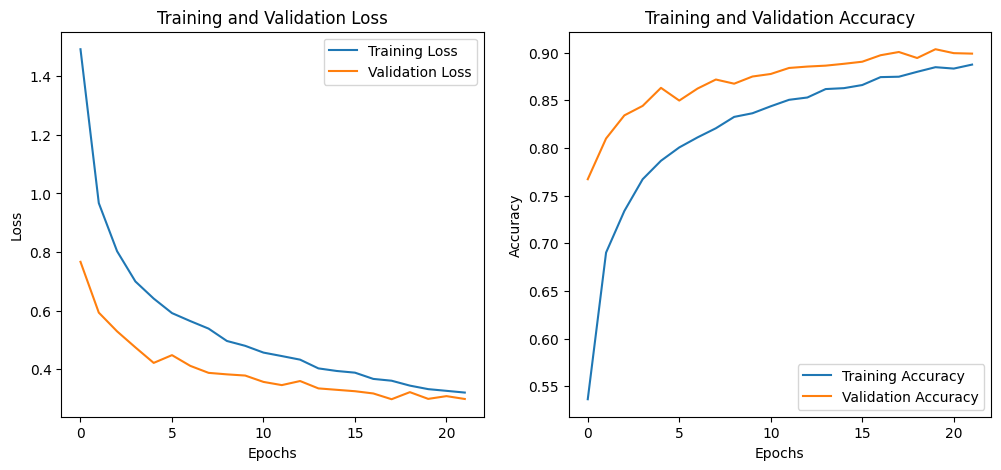

In [ ]:
visualize_model_performance(history16)

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.90      0.96      0.93       199
                     Pepper__bell___healthy       0.97      0.95      0.96       295
                      Potato___Early_blight       0.94      0.94      0.94       200
                       Potato___Late_blight       0.86      0.93      0.89       200
                           Potato___healthy       0.96      0.80      0.87        30
                      Tomato_Bacterial_spot       0.92      0.92      0.92       425
                        Tomato_Early_blight       0.84      0.62      0.71       200
                         Tomato_Late_blight       0.86      0.90      0.88       381
                           Tomato_Leaf_Mold       0.87      0.85      0.86       190
                  Tomato_Septoria_leaf_spot       0.90      0.86      0.88       354
Tomato_Spider_mites_Two_spotted_spider_mi

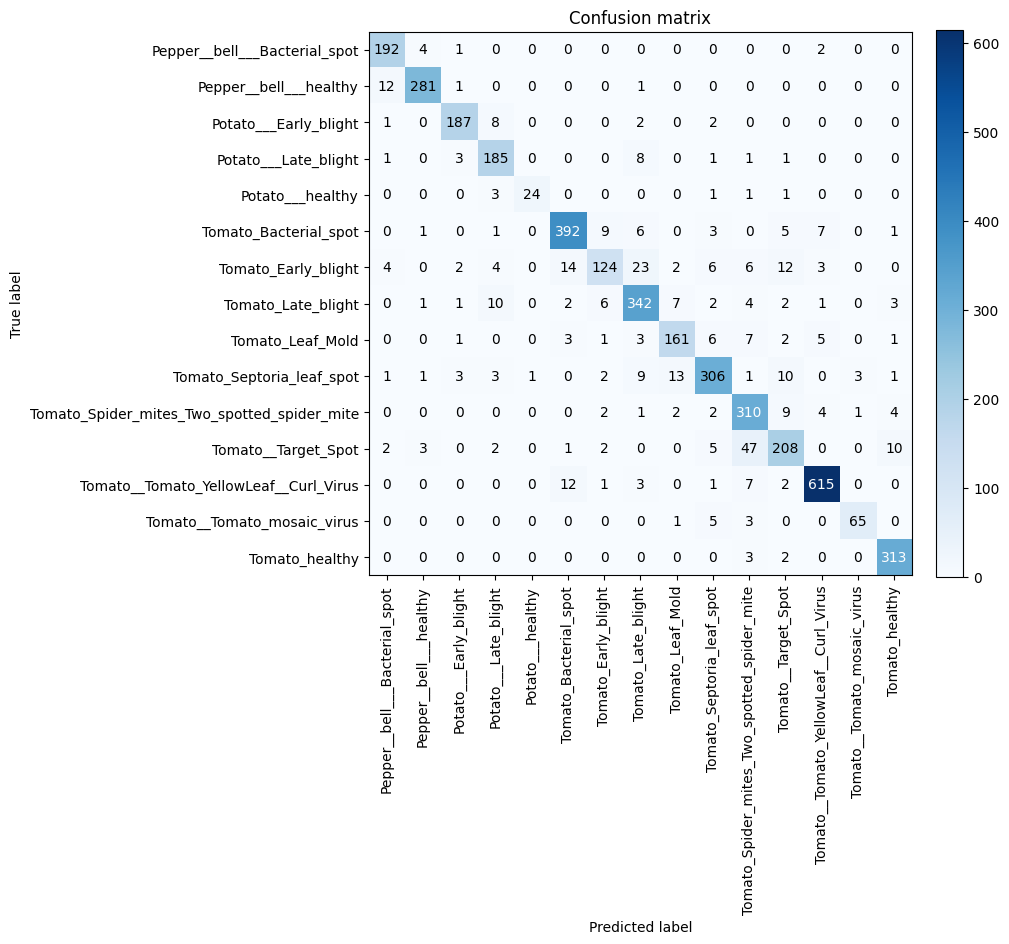

In [ ]:
# Plot the confusion matrix and classification report
evaluate_and_plot(model16, test_generator5)#

### ResNet50 with rmsprop

#### Model 17

In [ ]:
# rmsprop
# Learning rate of Adam
# Clearing backend

backend.clear_session()

# Fixing the seed for random number generators

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)



# Define the architecture of the new model
model16b = Sequential()
model16b.add(base_model5)  # Add the convolutional layers from ResNet-50
model16b.add(GlobalAveragePooling2D())  # Apply Global Average Pooling to reduce dimensions
model16b.add(Dense(128, activation="relu"))  # Add a dense layer with ReLU activation
model16b.add(Dropout(0.5))  # Add dropout for regularization
model16b.add(Dense(15, activation="softmax"))  # Output layer for classification

# Compile the model with the Adam optimizer and categorical cross-entropy loss
model16b.compile(optimizer=RMSprop(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Display a summary of the model architecture
model16b.summary()

# Define callbacks for model checkpointing and early stopping
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant16b.hdf5"), save_best_only=True, verbose=1)
es2 = EarlyStopping(patience=4)

# Create a list of callbacks to be used during training
callback_list = [check2, es2]

# Train the model using the data generators and specified callbacks for 50 epochs
history16b = model16b.fit(train_generator5, validation_data=test_generator5, epochs=50, callbacks=callback_list,batch_size =32)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 23,851,919
Trainable params: 264,207
Non-trainable params: 23,587,712
______________________________________

In [ ]:
model16b.evaluate(test_generator5)

129/129 [==============================] - 2s 12ms/step - loss: 0.4245 - accuracy: 0.8884


[0.42453861236572266, 0.8884037137031555]

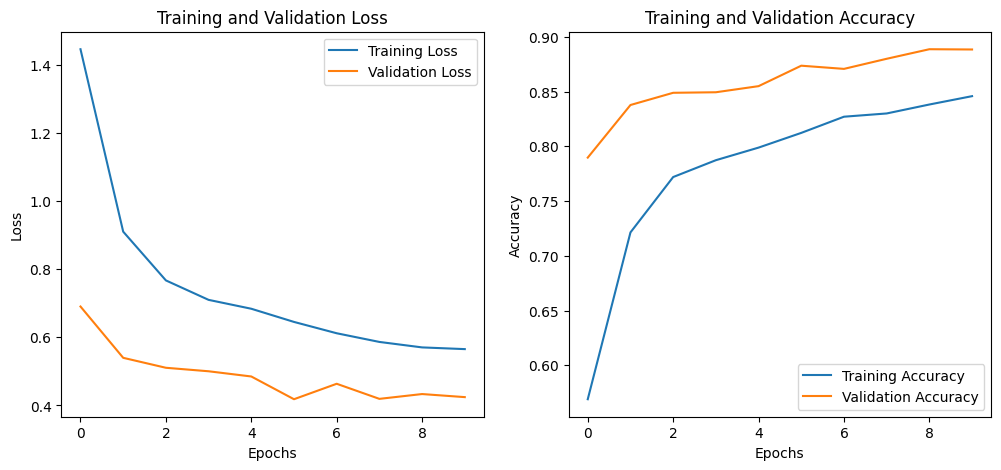

In [ ]:
visualize_model_performance(history16b)

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.92      0.91      0.92       199
                     Pepper__bell___healthy       0.93      0.97      0.95       295
                      Potato___Early_blight       0.97      0.92      0.95       200
                       Potato___Late_blight       0.82      0.94      0.88       200
                           Potato___healthy       0.96      0.73      0.83        30
                      Tomato_Bacterial_spot       0.93      0.96      0.94       425
                        Tomato_Early_blight       0.76      0.65      0.70       200
                         Tomato_Late_blight       0.84      0.88      0.86       381
                           Tomato_Leaf_Mold       0.89      0.70      0.78       190
                  Tomato_Septoria_leaf_spot       0.82      0.89      0.85       354
Tomato_Spider_mites_Two_spotted_spider_mi

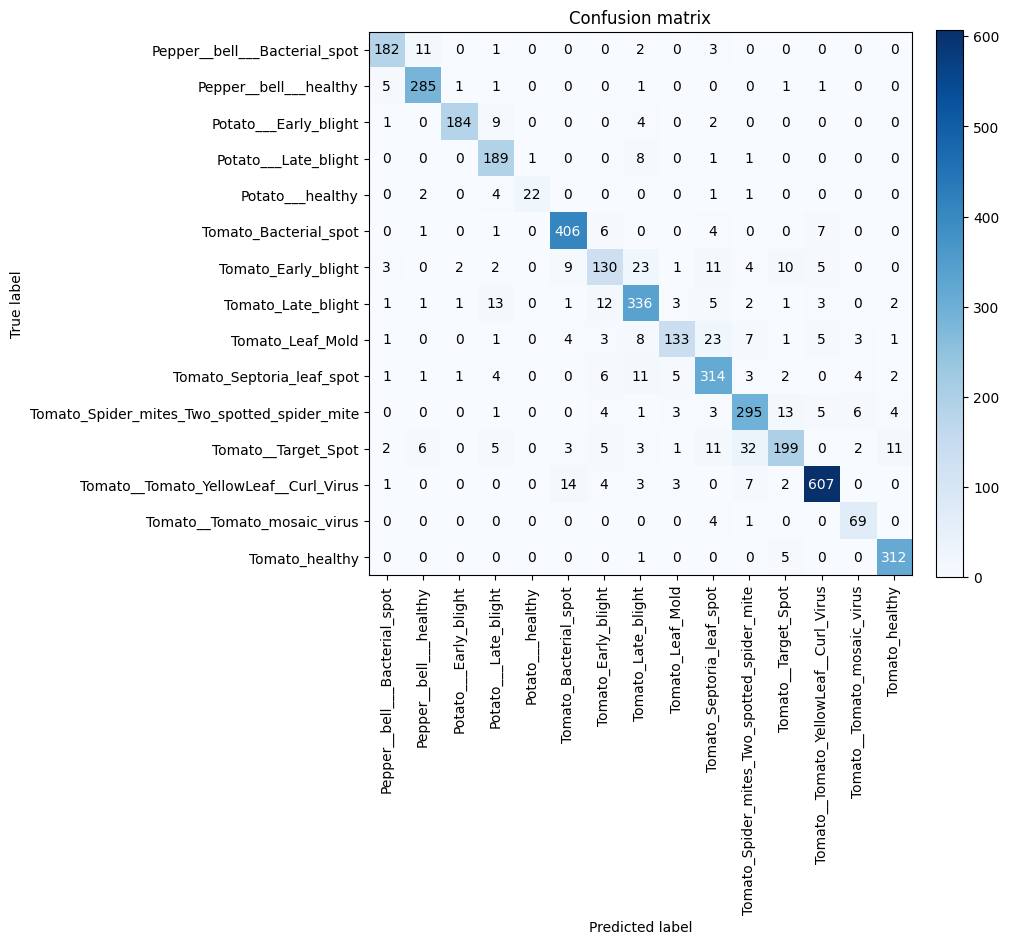

In [ ]:
# plot the classifcation report and confusion matrix
evaluate_and_plot(model16b, test_generator5)#

### resent50 with  Adamax


#### model 18

In [ ]:
### resent Adamax

# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


# Define the architecture of the new model
model16c = Sequential()
model16c.add(base_model5)  # Add the convolutional layers from ResNet-50
model16c.add(GlobalAveragePooling2D())  # Apply Global Average Pooling to reduce dimensions
model16c.add(Dense(128, activation="relu"))  # Add a dense layer with ReLU activation
model16c.add(Dropout(0.7))  # Add dropout for regularization
model16c.add(Dense(15, activation="softmax"))  # Output layer for classification

# Compile the model with the Adam optimizer and categorical cross-entropy loss
model16c.compile(optimizer=Adamax(), loss="categorical_crossentropy", metrics=["accuracy"])

# Display a summary of the model architecture
model16c.summary()

# Define callbacks for model checkpointing and early stopping
check2 = ModelCheckpoint(os.path.join(model_filepath, "plant26c.hdf5"), save_best_only=True, verbose=1)
es2 = EarlyStopping(patience=4)

# Create a list of callbacks to be used during training
callback_list = [check2, es2]

# Train the model using the data generators and specified callbacks for 50 epochs
history16c = model16c.fit(train_generator5, validation_data=test_generator5, epochs=50, callbacks=callback_list,batch_size =32)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 23,851,919
Trainable 

517/517 [==============================] - 8s 16ms/step - loss: 0.4729 - accuracy: 0.8378 - val_loss: 0.3265 - val_accuracy: 0.8986
Epoch 23/50
517/517 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.8428
Epoch 23: val_loss improved from 0.32652 to 0.32070, saving model to D:/Ajala ai\plant26c.hdf5
517/517 [==============================] - 8s 16ms/step - loss: 0.4600 - accuracy: 0.8428 - val_loss: 0.3207 - val_accuracy: 0.8964
Epoch 24/50
517/517 [==============================] - ETA: 0s - loss: 0.4537 - accuracy: 0.8453
Epoch 24: val_loss improved from 0.32070 to 0.31366, saving model to D:/Ajala ai\plant26c.hdf5
517/517 [==============================] - 8s 16ms/step - loss: 0.4537 - accuracy: 0.8453 - val_loss: 0.3137 - val_accuracy: 0.8986
Epoch 25/50
514/517 [============================>.] - ETA: 0s - loss: 0.4325 - accuracy: 0.8546
Epoch 25: val_loss improved from 0.31366 to 0.31270, saving model to D:/Ajala ai\plant26c.hdf5
517/517 [===================

In [ ]:
model16c.evaluate(test_generator5)

129/129 [==============================] - 1s 11ms/step - loss: 0.2878 - accuracy: 0.9078


[0.28775554895401, 0.9078117609024048]

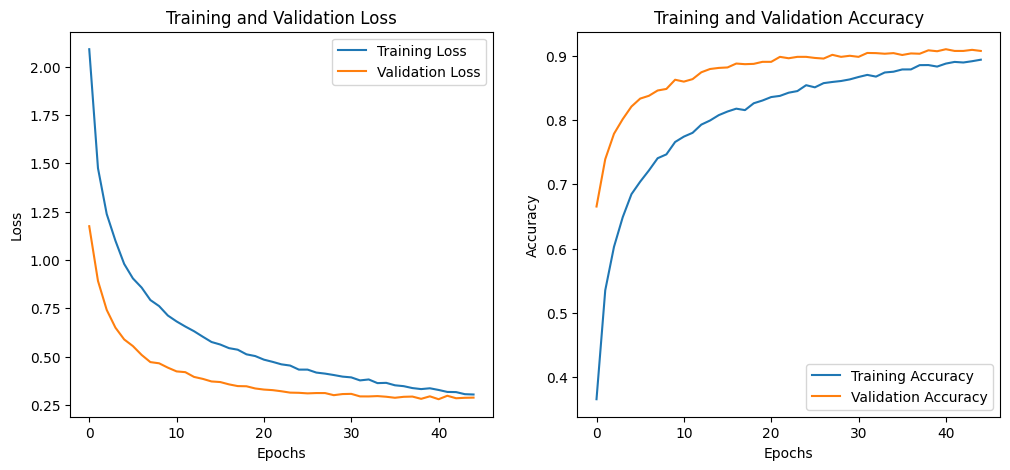

In [ ]:
visualize_model_performance(history16c)

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.93      0.94      0.94       199
                     Pepper__bell___healthy       0.95      0.98      0.96       295
                      Potato___Early_blight       0.95      0.94      0.95       200
                       Potato___Late_blight       0.91      0.93      0.92       200
                           Potato___healthy       0.93      0.83      0.88        30
                      Tomato_Bacterial_spot       0.91      0.96      0.94       425
                        Tomato_Early_blight       0.83      0.64      0.72       200
                         Tomato_Late_blight       0.84      0.91      0.88       381
                           Tomato_Leaf_Mold       0.92      0.84      0.88       190
                  Tomato_Septoria_leaf_spot       0.89      0.90      0.89       354
Tomato_Spider_mites_Two_spotted_spider_mi

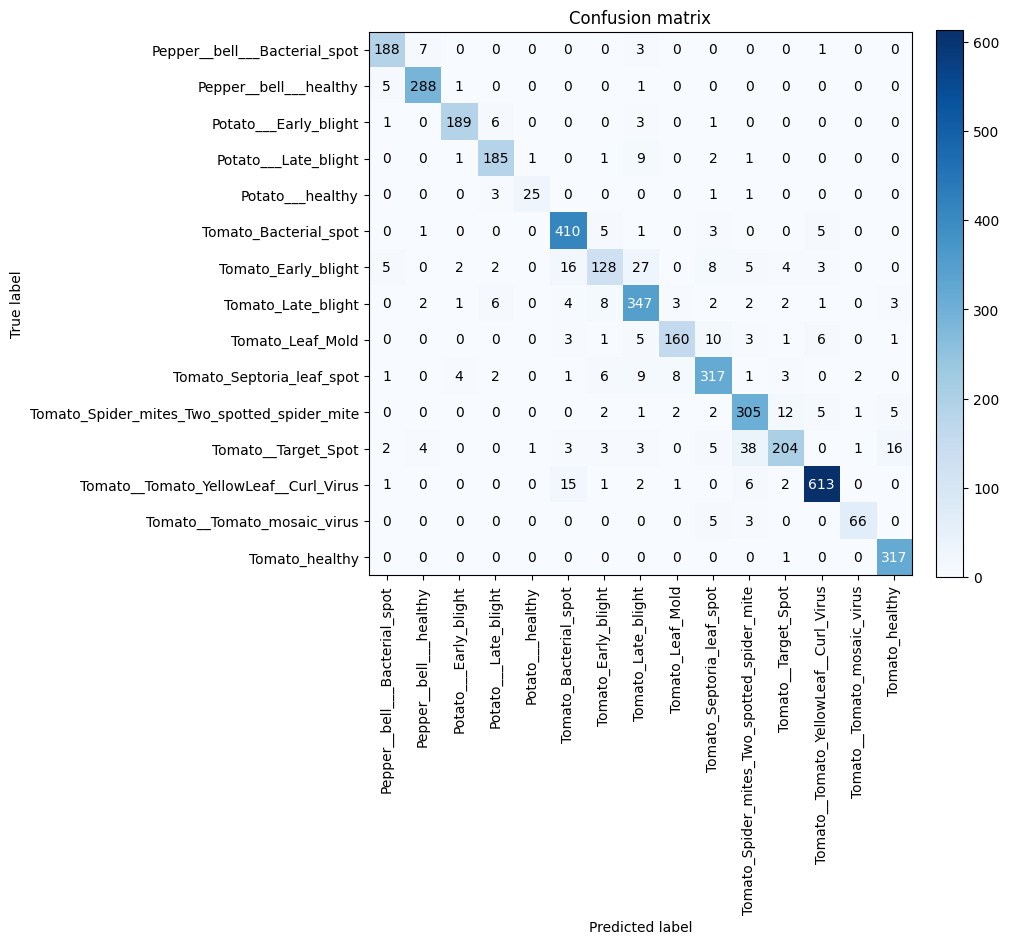

In [ ]:
# get the classication report and confusion matrix of all the model
evaluate_and_plot(model16c, test_generator5)#

### Visualize the validation accuracy of Resnet 50 with different optimizers

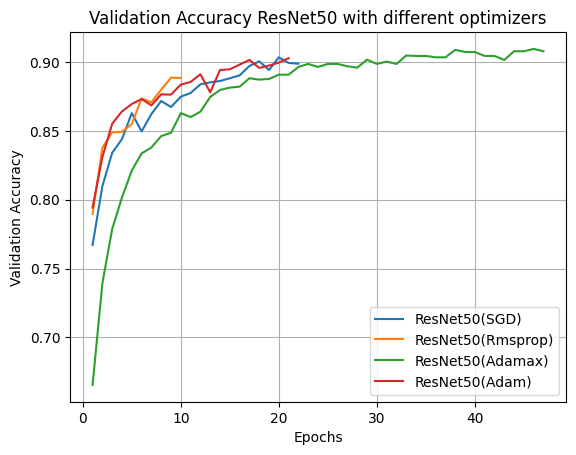

In [ ]:
# Define the training logs for each model
models_logs = {

    "ResNet50(SGD)": [ # the validation accuracy for ResNet50(SGD)
        0.7671, 0.8098, 0.8341, 0.8440, 0.8629,
        0.8496, 0.8622, 0.8717, 0.8673, 0.8748,
        0.8775, 0.8838, 0.8852, 0.8862, 0.8882,
        0.8903, 0.8971, 0.9005, 0.8942, 0.9034,
        0.8993, 0.8988
    ],
    "ResNet50(Rmsprop)": [  #  the validation accuracy for ResNet50(Rmsprop)
        0.7897, 0.8377, 0.8489, 0.8493, 0.8549,
        0.8736, 0.8707, 0.8799, 0.8886, 0.8884
    ],
    "ResNet50(Adamax)": [  # Add the validation accuracy for ResNet50(Adamax)
       0.6655, 0.7392, 0.7787, 0.8016, 0.8212,
        0.8336, 0.8379, 0.8462, 0.8486, 0.8629,
        0.8600, 0.8639, 0.8746, 0.8797, 0.8814,
        0.8821, 0.8882, 0.8872, 0.8877, 0.8908,
        0.8908, 0.8964, 0.8986, 0.8964, 0.8986,
        0.8986, 0.8969, 0.8959, 0.9017, 0.8986,
        0.9003, 0.8986, 0.9047, 0.9044, 0.9044,
        0.9034, 0.9034, 0.9088, 0.9073, 0.9072,
        0.9044, 0.9044, 0.9015, 0.9078, 0.9078,
        0.9095, 0.9078
    ],
    "ResNet50(Adam)": [
        # the validation accuracy for ResNet50 (Adam)
        0.7943, 0.8309, 0.8552, 0.8641, 0.8695,
        0.8731, 0.8685, 0.8765, 0.8763, 0.8836,
        0.8855, 0.8911, 0.8780, 0.8942, 0.8947,
        0.8981, 0.9015, 0.8957, 0.8974, 0.8996,
        0.9027,
    ],
}

# Find the maximum number of epochs among all models
max_epochs = max(len(val_acc) for val_acc in models_logs.values())

# Create x-axis values (epochs) based on the maximum number of epochs
epochs = list(range(1, max_epochs + 1))

# Plot the validation accuracy for each model up to the maximum number of epochs
for model_name, val_acc in models_logs.items():
    # If the model has fewer epochs, pad with NaN values to match the maximum number of epochs
    val_acc_padded = val_acc + [float('nan')] * (max_epochs - len(val_acc))
    plt.plot(epochs, val_acc_padded, label=model_name)

# Customize the plot
plt.title("Validation Accuracy ResNet50 with different optimizers")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)

### comparative analysis of the performance of the best pretrain and custom model

 -best custom model has for convolutional layer, optimzer = adam

 -best custom model is ResNet 50 with adamax optimizers


### Visualizing the accuracy, precision, recall and f1 score of the best pretrained  and  custom model

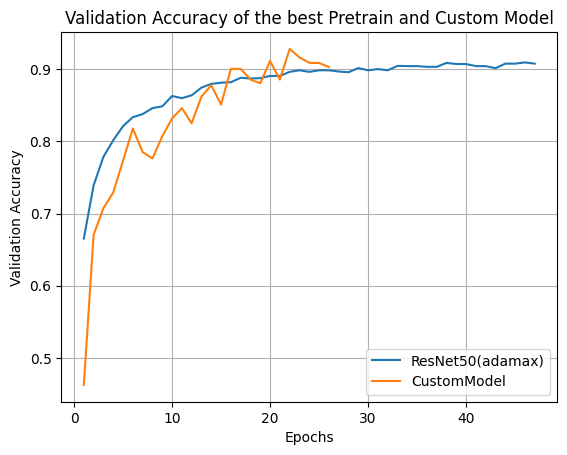

In [ ]:

# Define the training logs for ResNet50 and CustomModel
models_logs = {
    "ResNet50(adamax)": [
              0.6655, 0.7392, 0.7787, 0.8016, 0.8212,
        0.8336, 0.8379, 0.8462, 0.8486, 0.8629,
        0.8600, 0.8639, 0.8746, 0.8797, 0.8814,
        0.8821, 0.8882, 0.8872, 0.8877, 0.8908,
        0.8908, 0.8964, 0.8986, 0.8964, 0.8986,
        0.8986, 0.8969, 0.8959, 0.9017, 0.8986,
        0.9003, 0.8986, 0.9047, 0.9044, 0.9044,
        0.9034, 0.9034, 0.9088, 0.9073, 0.9072,
        0.9044, 0.9044, 0.9015, 0.9078, 0.9078,
        0.9095, 0.9078

    ],
        "CustomModel": [ 0.4626, 0.6707, 0.7075, 0.7292, 0.7732,
    0.8179, 0.7852, 0.7764, 0.8071, 0.8318,
    0.8462, 0.8252, 0.8621, 0.8779, 0.8511,
    0.9004, 0.9006, 0.8857, 0.8806, 0.9116,
    0.8857, 0.9282, 0.9165, 0.9089, 0.9087,
    0.9031
    ],
}

# Find the maximum number of epochs among all models
max_epochs = max(len(val_acc) for val_acc in models_logs.values())

# Create x-axis values (epochs) based on the maximum number of epochs
epochs = list(range(1, max_epochs + 1))

# Plot the validation accuracy for ResNet50 and CustomModel up to the maximum number of epochs
for model_name, val_acc in models_logs.items():
    # If the model has fewer epochs, pad with NaN values to match the maximum number of epochs
    val_acc_padded = val_acc + [float('nan')] * (max_epochs - len(val_acc))
    plt.plot(epochs, val_acc_padded, label=model_name)

# Customize the plot
plt.title("Validation Accuracy of the best Pretrain and Custom Model")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### visualizing the accuracy,precision and recall of the best pretrain and custom model

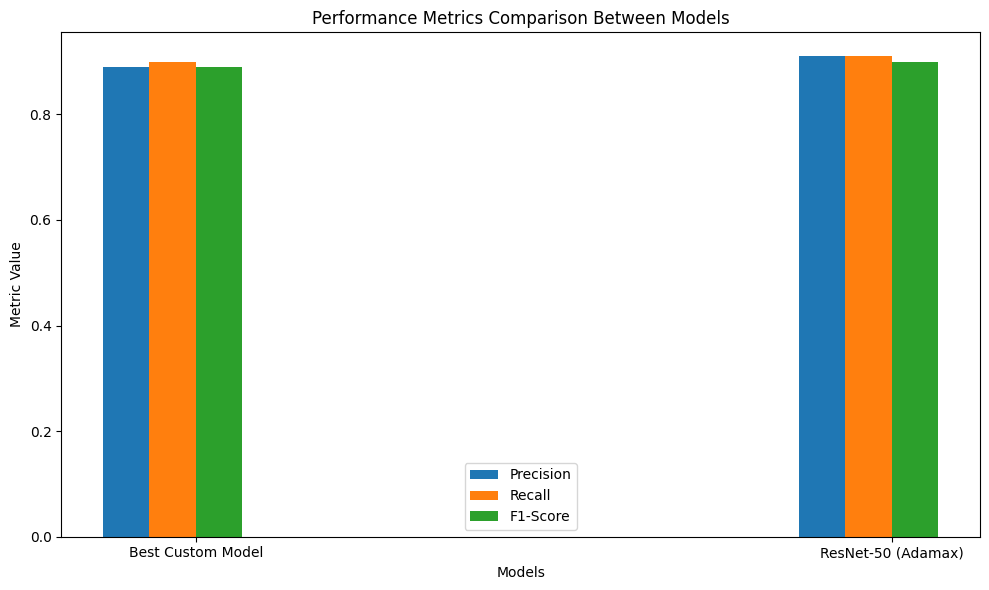

In [ ]:
# Define the model names
models = ["Best Custom Model", "ResNet-50 (Adamax)"]

# Define the performance metrics
metrics = [ "Precision", "Recall", "F1-Score"]

# Define the values for the best custom model
custom_model_values = [ 0.890, 0.900, 0.890]

# Define the values for ResNet-50 (Adamax)
resnet50_values = [ 0.910, 0.910, 0.900]

# Set the width of each bar
bar_width = 0.2

# Define the x-axis positions for the bars
x = np.arange(len(models))

# Create a subplot for the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate through each metric and plot grouped bars
for i, metric in enumerate(metrics):
    custom_bars = ax.bar(x - bar_width/2 + i*bar_width/len(metrics), [custom_model_values[i], resnet50_values[i]],
                         bar_width/len(metrics), label=f"{metric}")

# Customize the plot
ax.set_xlabel('Models')
ax.set_ylabel('Metric Value')
ax.set_title('Performance Metrics Comparison Between Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


The performance of the best pre-trained and custom models is almost identical, with the custom model achieving an accuracy of 90%, precision of 90%, and recall of 89%. On the other hand, the pre-trained model achieved an accuracy of 91%, precision of 91%, and recall of 91%, along with a lower loss (0.208), implying that the model is more efficient at reducing the loss compared to the custom model.In conclusion, both models performed well in multi-plant disease classification, as demonstrated by the results of the confusion matrices